Text(0, 0.5, 'Log(L/L$_\\odot$)')

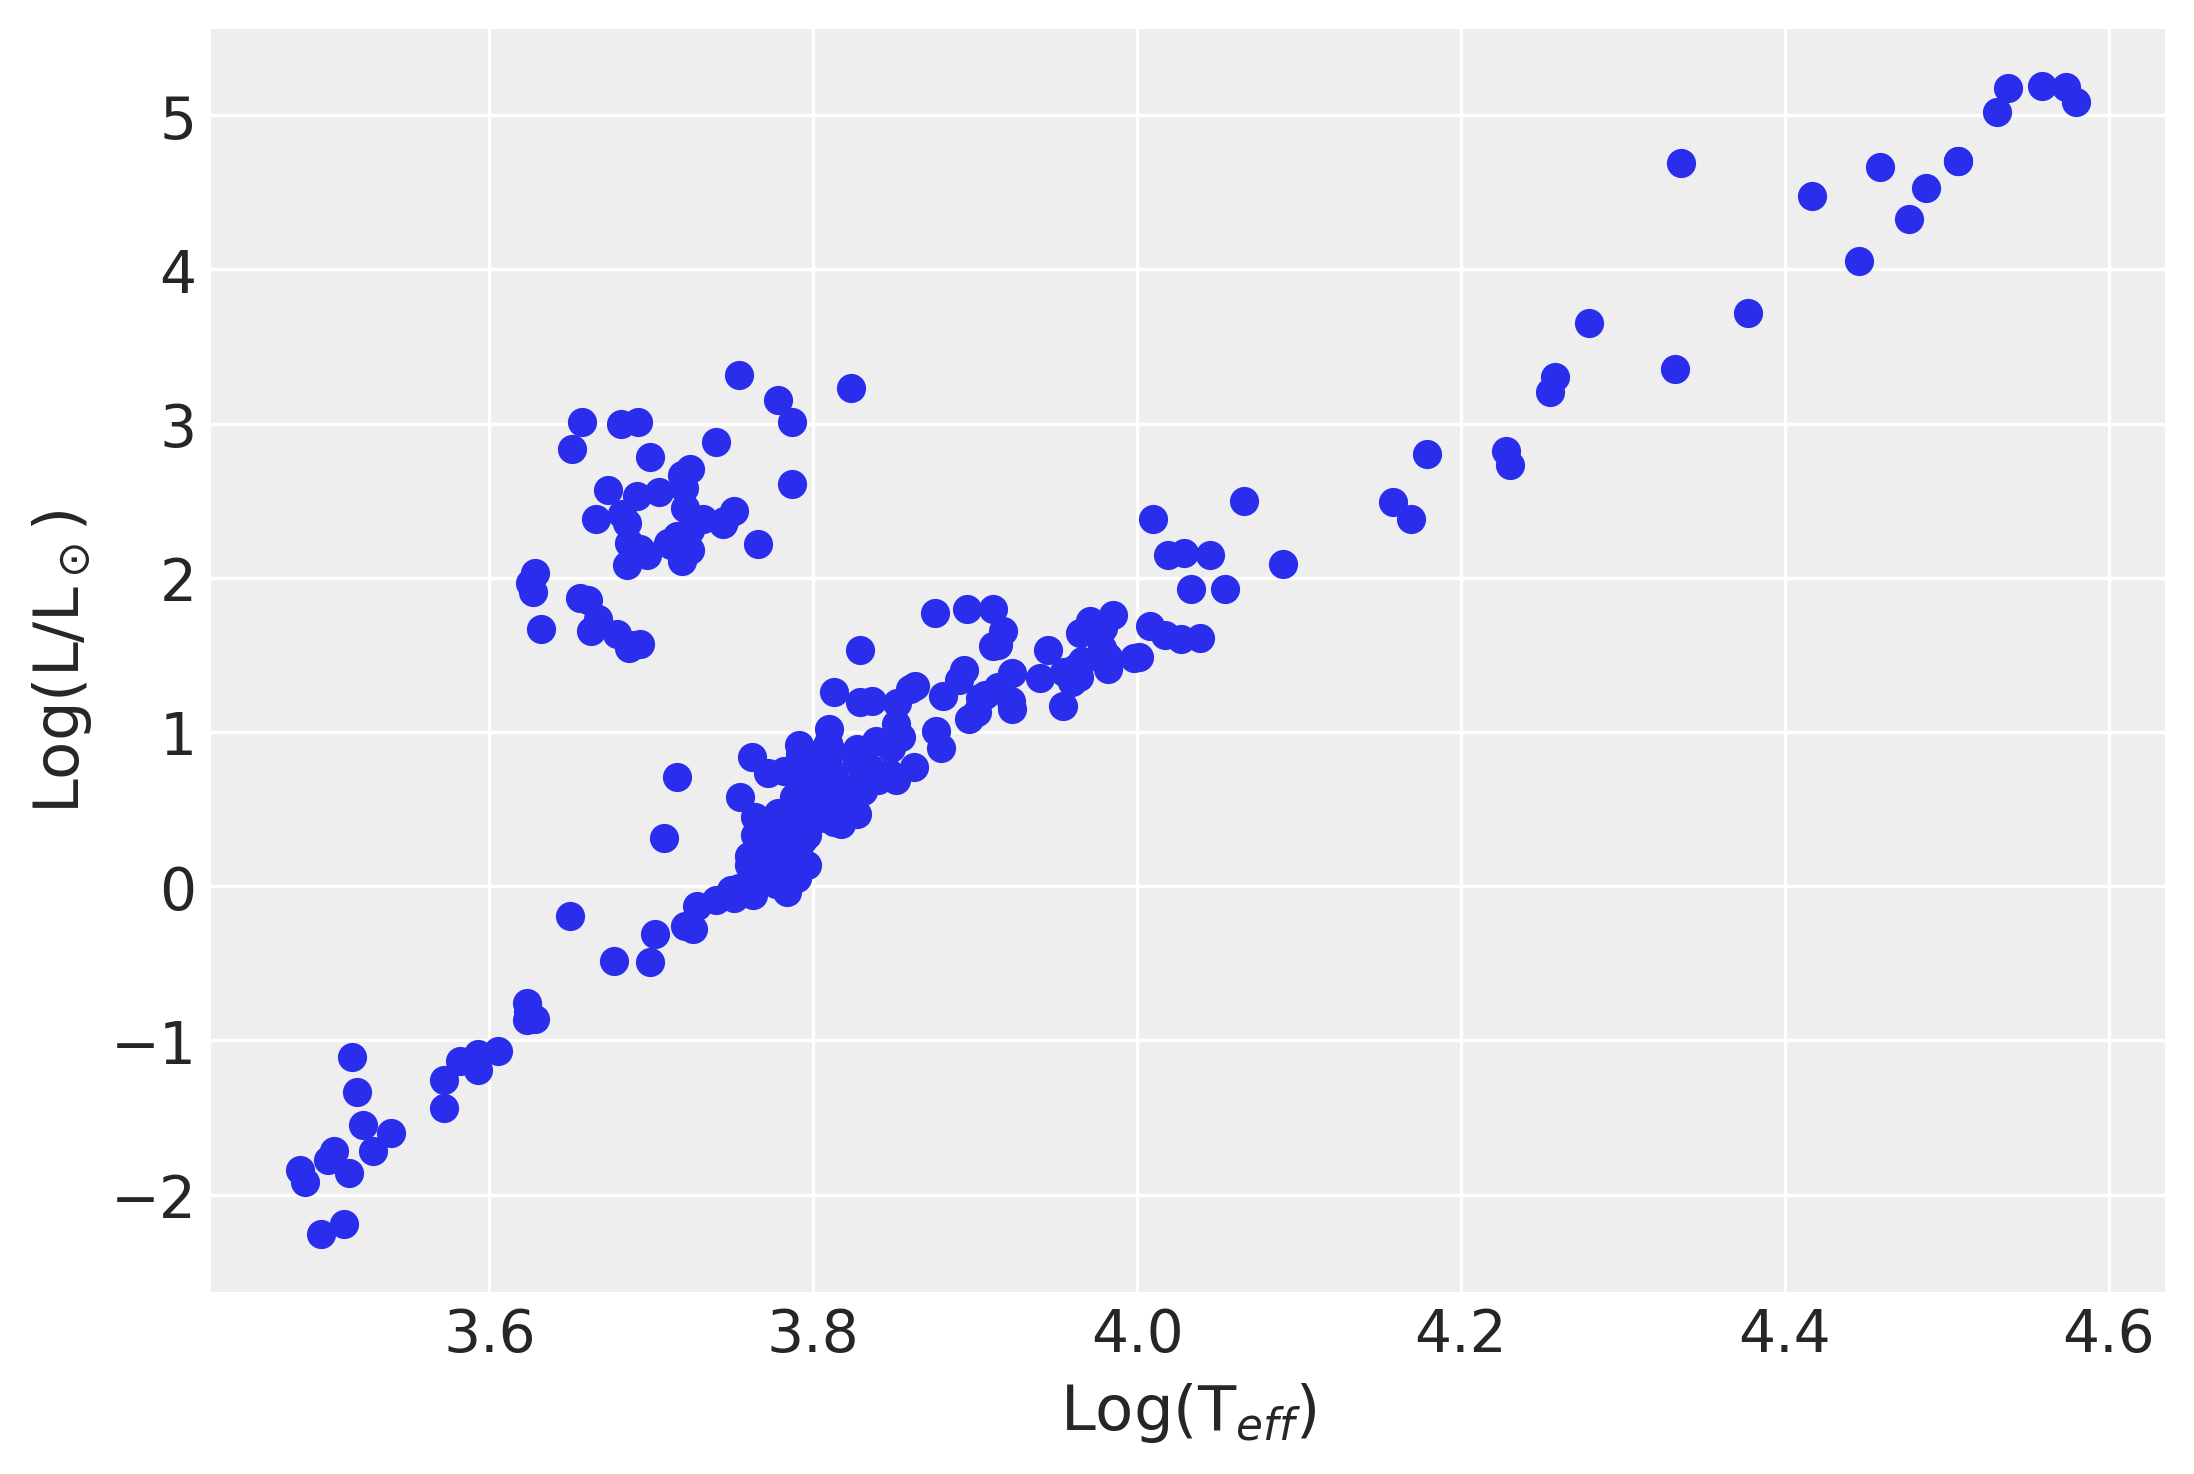

In [386]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

df = Table.read('https://www.astro.keele.ac.uk/jkt/debcat/debs.dat', format='ascii').to_pandas()

df2 = Table.read('https://www.astro.keele.ac.uk/jkt/debcat/debs.dat', format='ascii').to_pandas()

logT1_2 = df2["logT1"]
logL1_2 = df2["logL1"]

#filter out erroneous values
df = df[df['logL1'] > -3]

logT1 = df["logT1"]
logT1 = np.array(logT1)
logL1 = df["logL1"]
logL1 = np.array(logL1)

plt.scatter(logT1, logL1)
plt.xlabel('Log(T$_{eff}$)')
plt.ylabel('Log(L/L$_\odot$)')

Text(0, 0.5, 'Log(L/L$_\\odot$)')

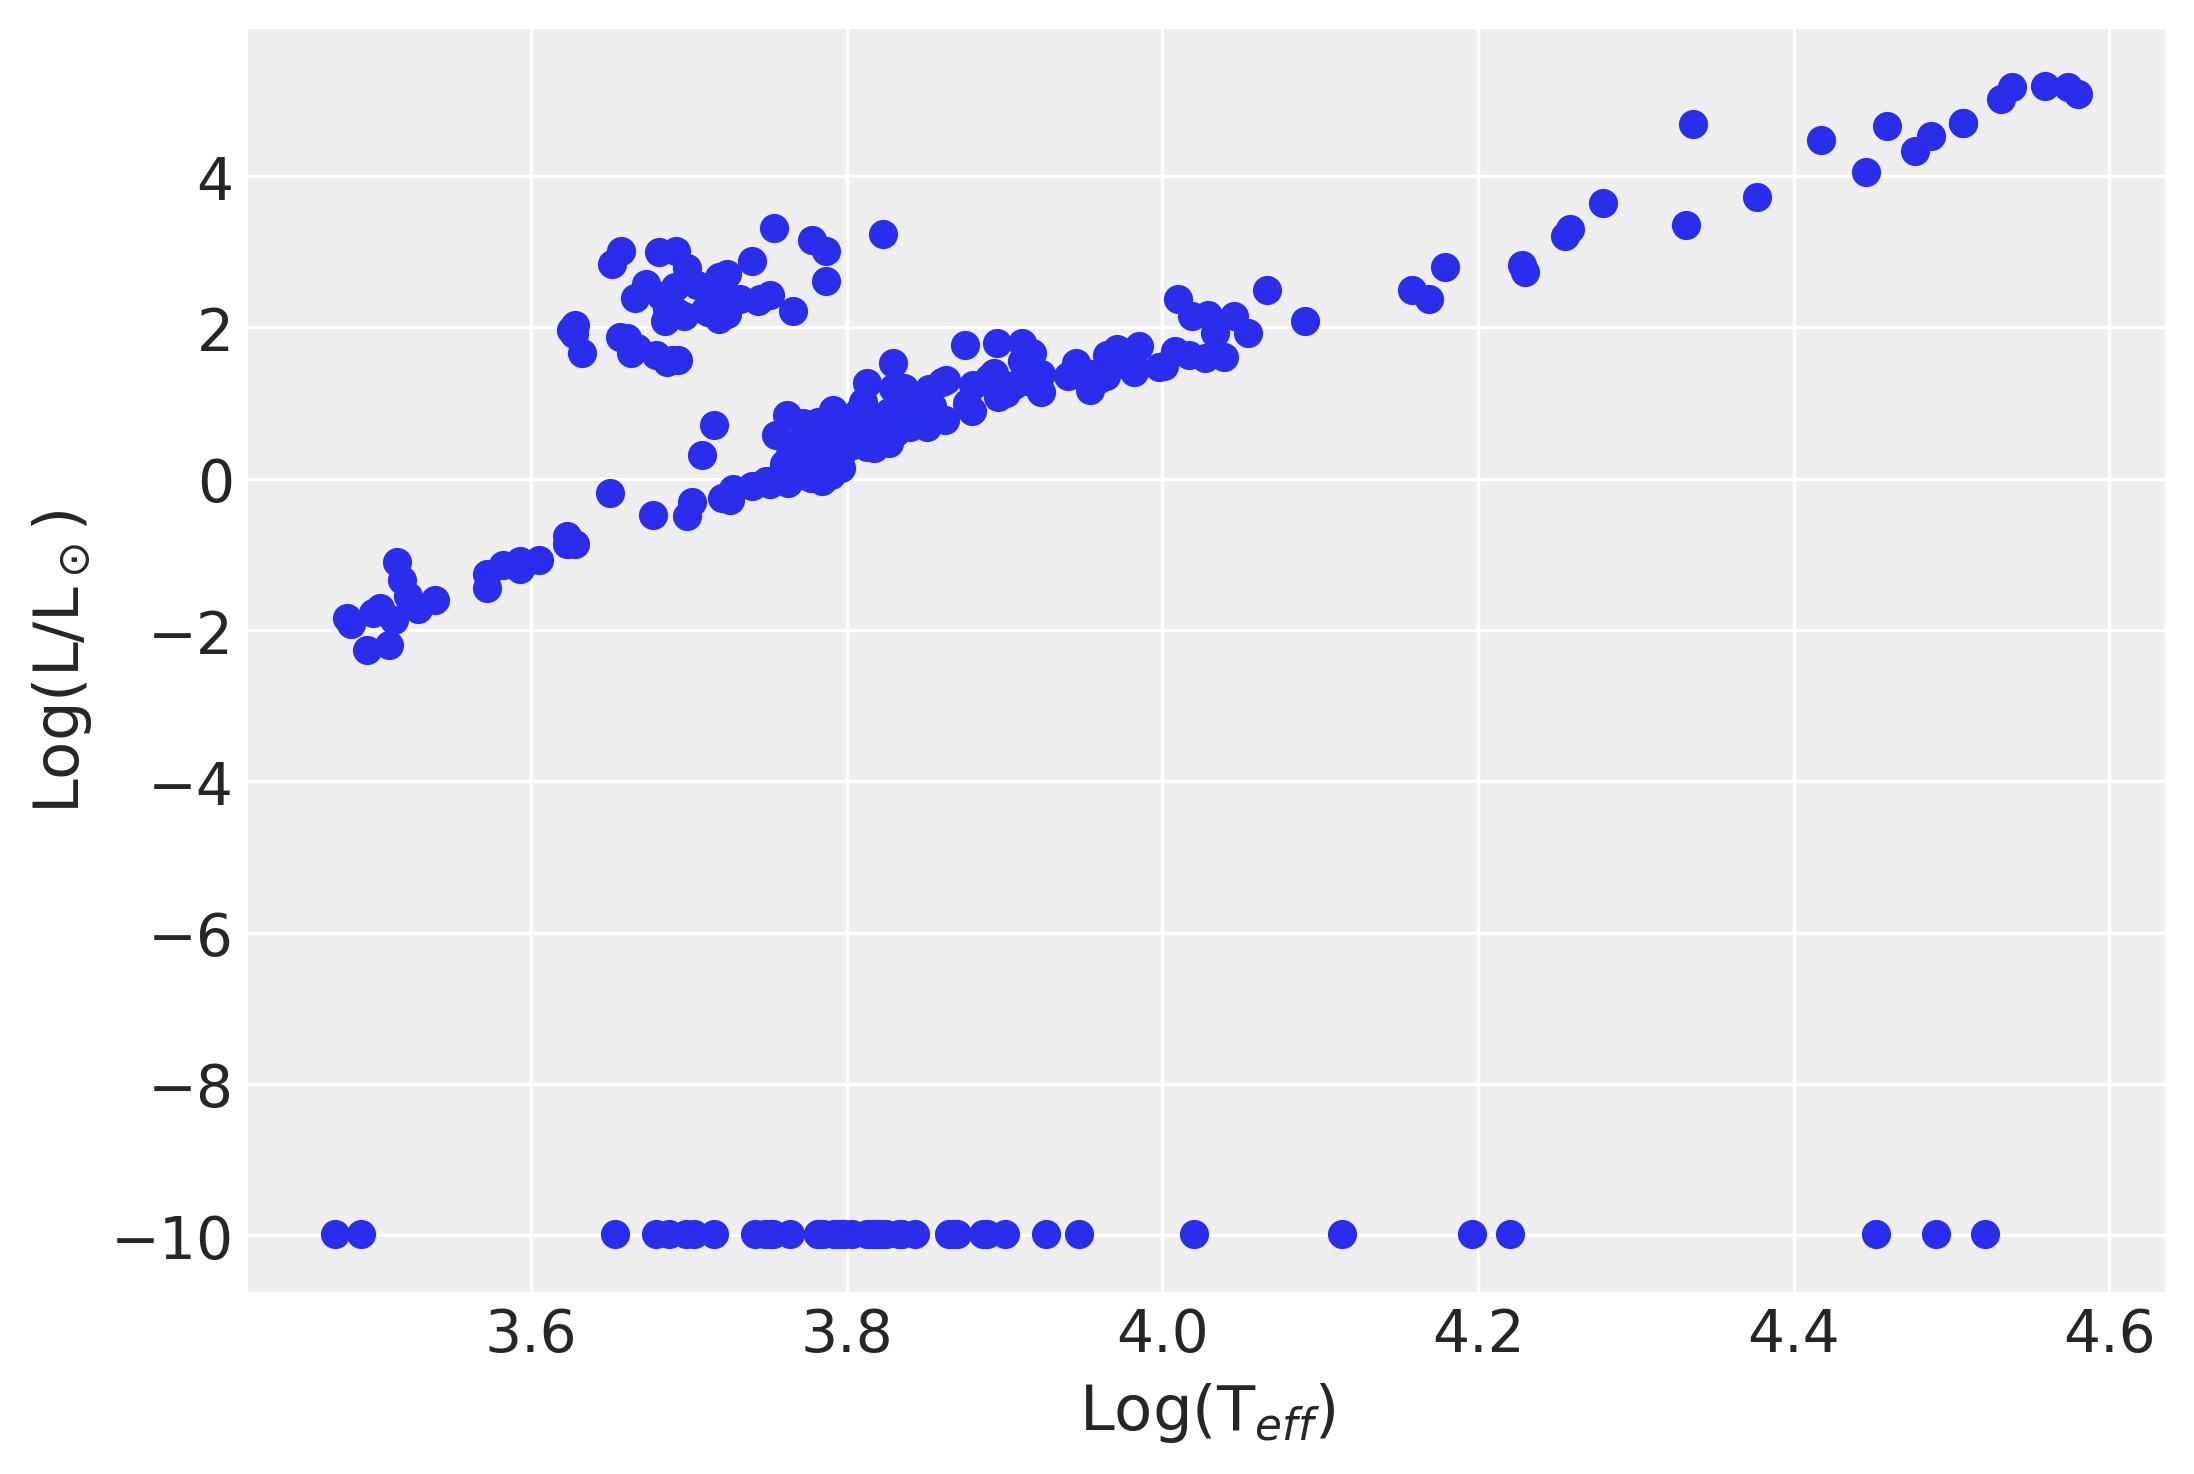

In [387]:
plt.scatter(logT1_2, logL1_2)
plt.xlabel('Log(T$_{eff}$)')
plt.ylabel('Log(L/L$_\odot$)')

(array([ 2.,  4.,  4.,  2.,  6.,  3.,  1.,  4.,  8., 16., 29., 29., 23.,
        12., 17., 22., 11., 13., 16.,  8.,  7.,  5.,  5.,  1.,  1.,  1.,
         1.,  3.,  3.,  5.]),
 array([-2.258     , -2.00983333, -1.76166667, -1.5135    , -1.26533333,
        -1.01716667, -0.769     , -0.52083333, -0.27266667, -0.0245    ,
         0.22366667,  0.47183333,  0.72      ,  0.96816667,  1.21633333,
         1.4645    ,  1.71266667,  1.96083333,  2.209     ,  2.45716667,
         2.70533333,  2.9535    ,  3.20166667,  3.44983333,  3.698     ,
         3.94616667,  4.19433333,  4.4425    ,  4.69066667,  4.93883333,
         5.187     ]),
 <BarContainer object of 30 artists>)

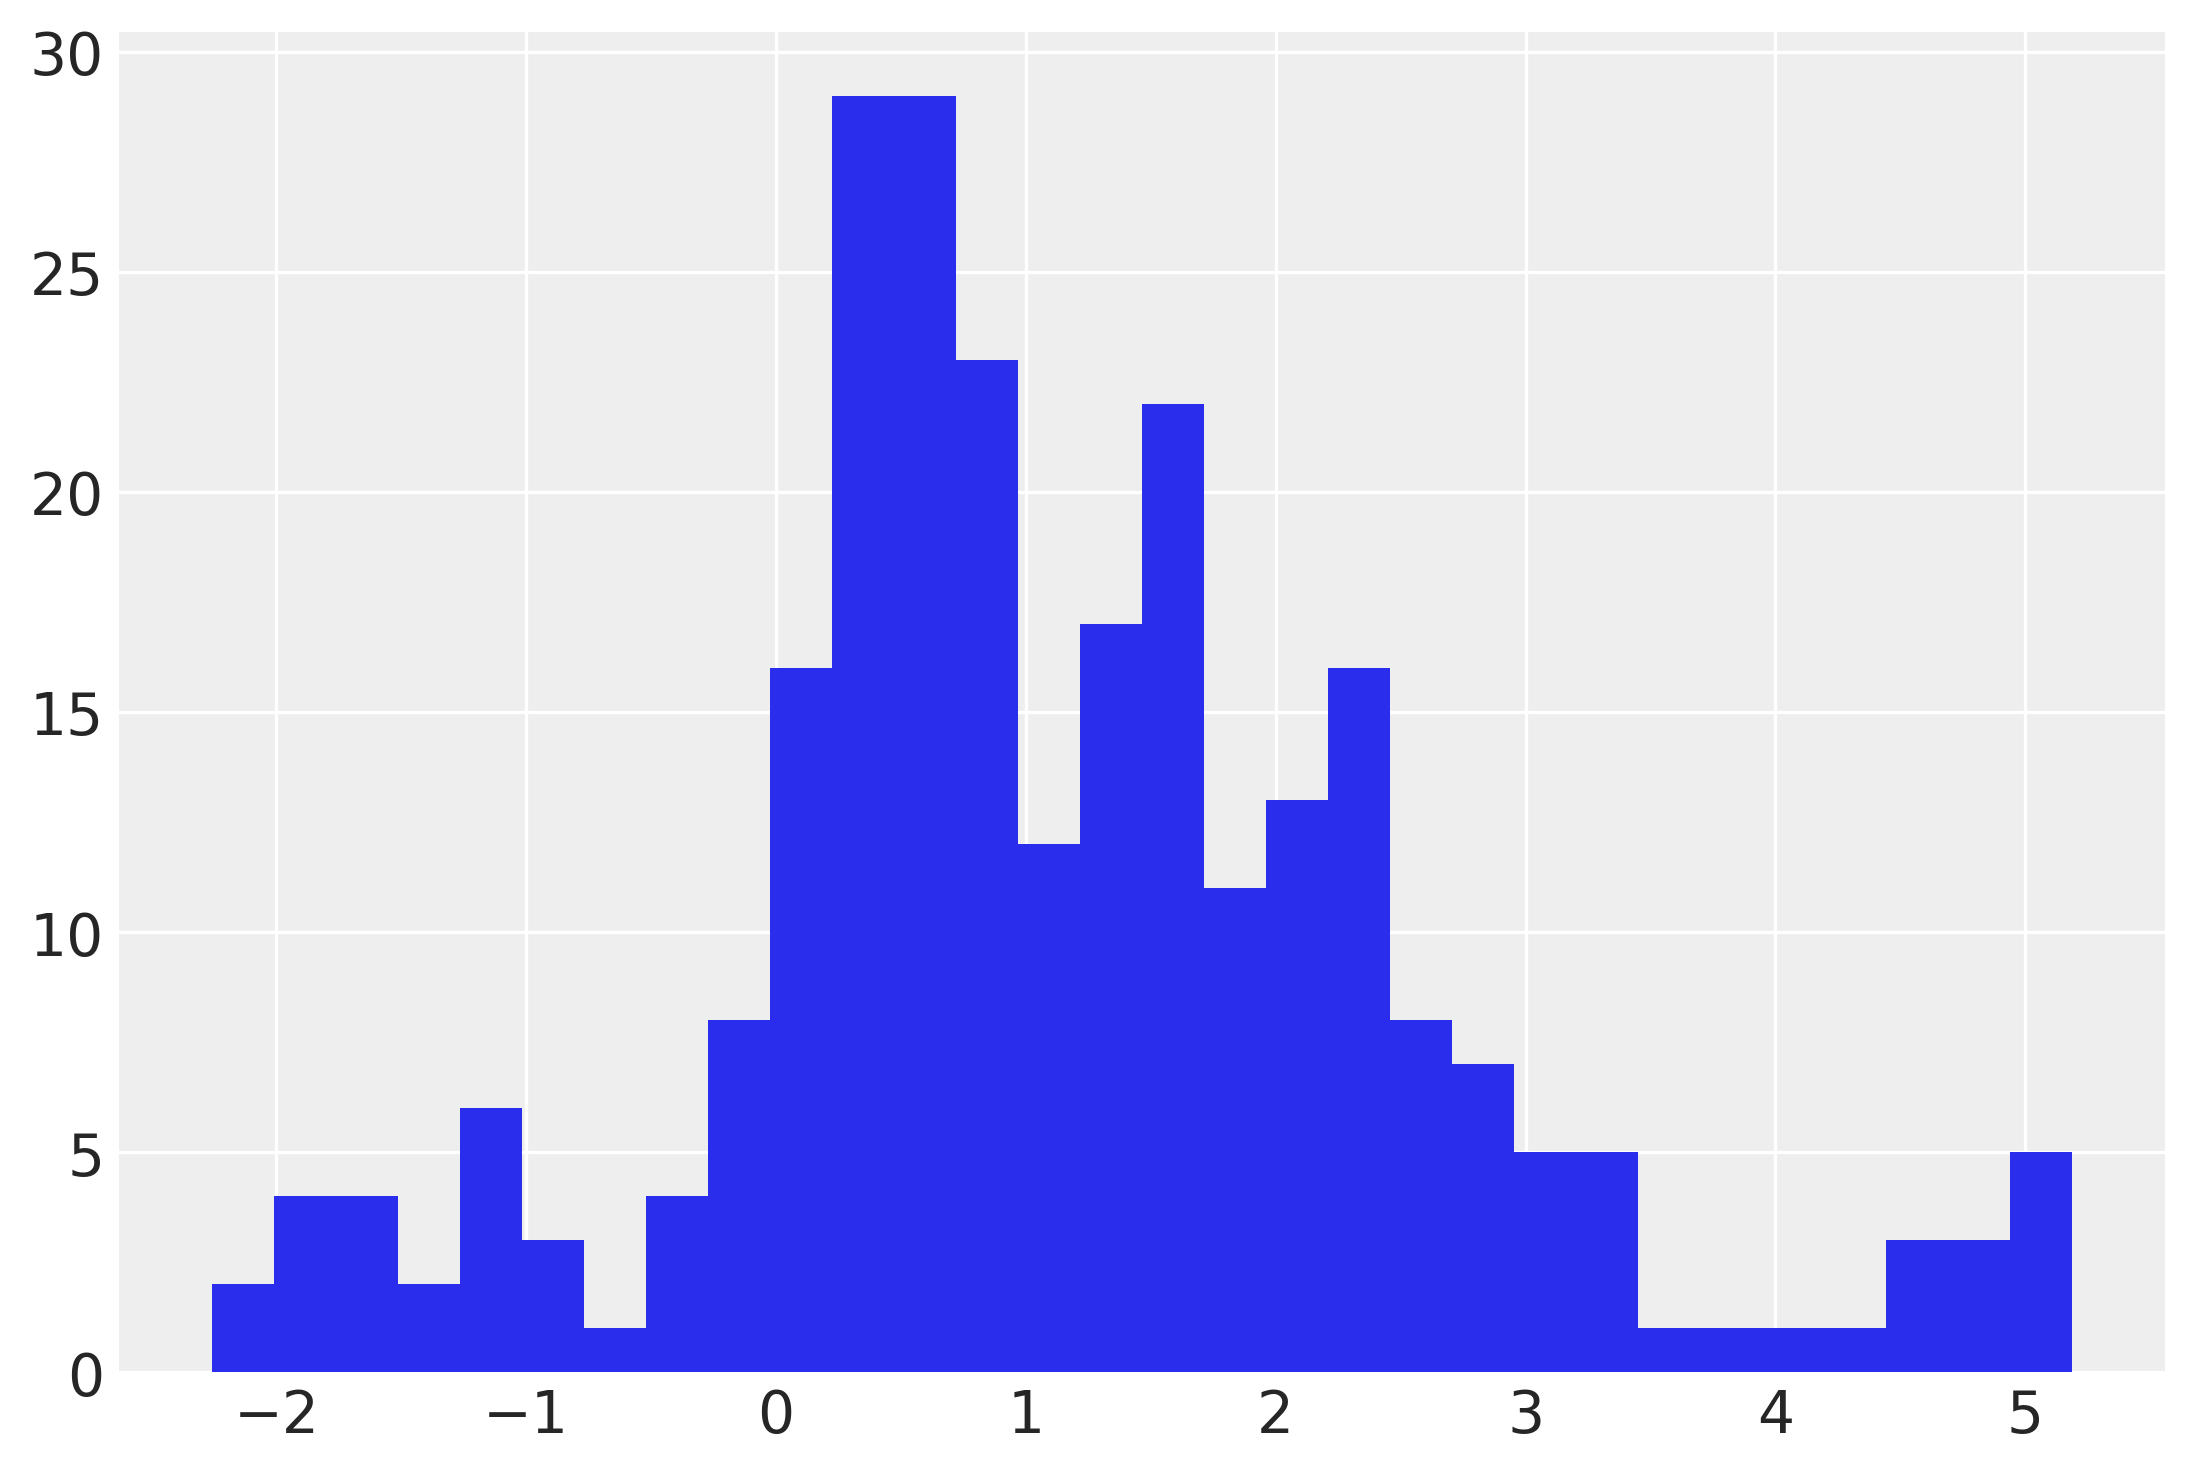

In [388]:
plt.hist(logL1, bins=30)

Text(0, 0.5, 'Log(L/L$_\\odot$)')

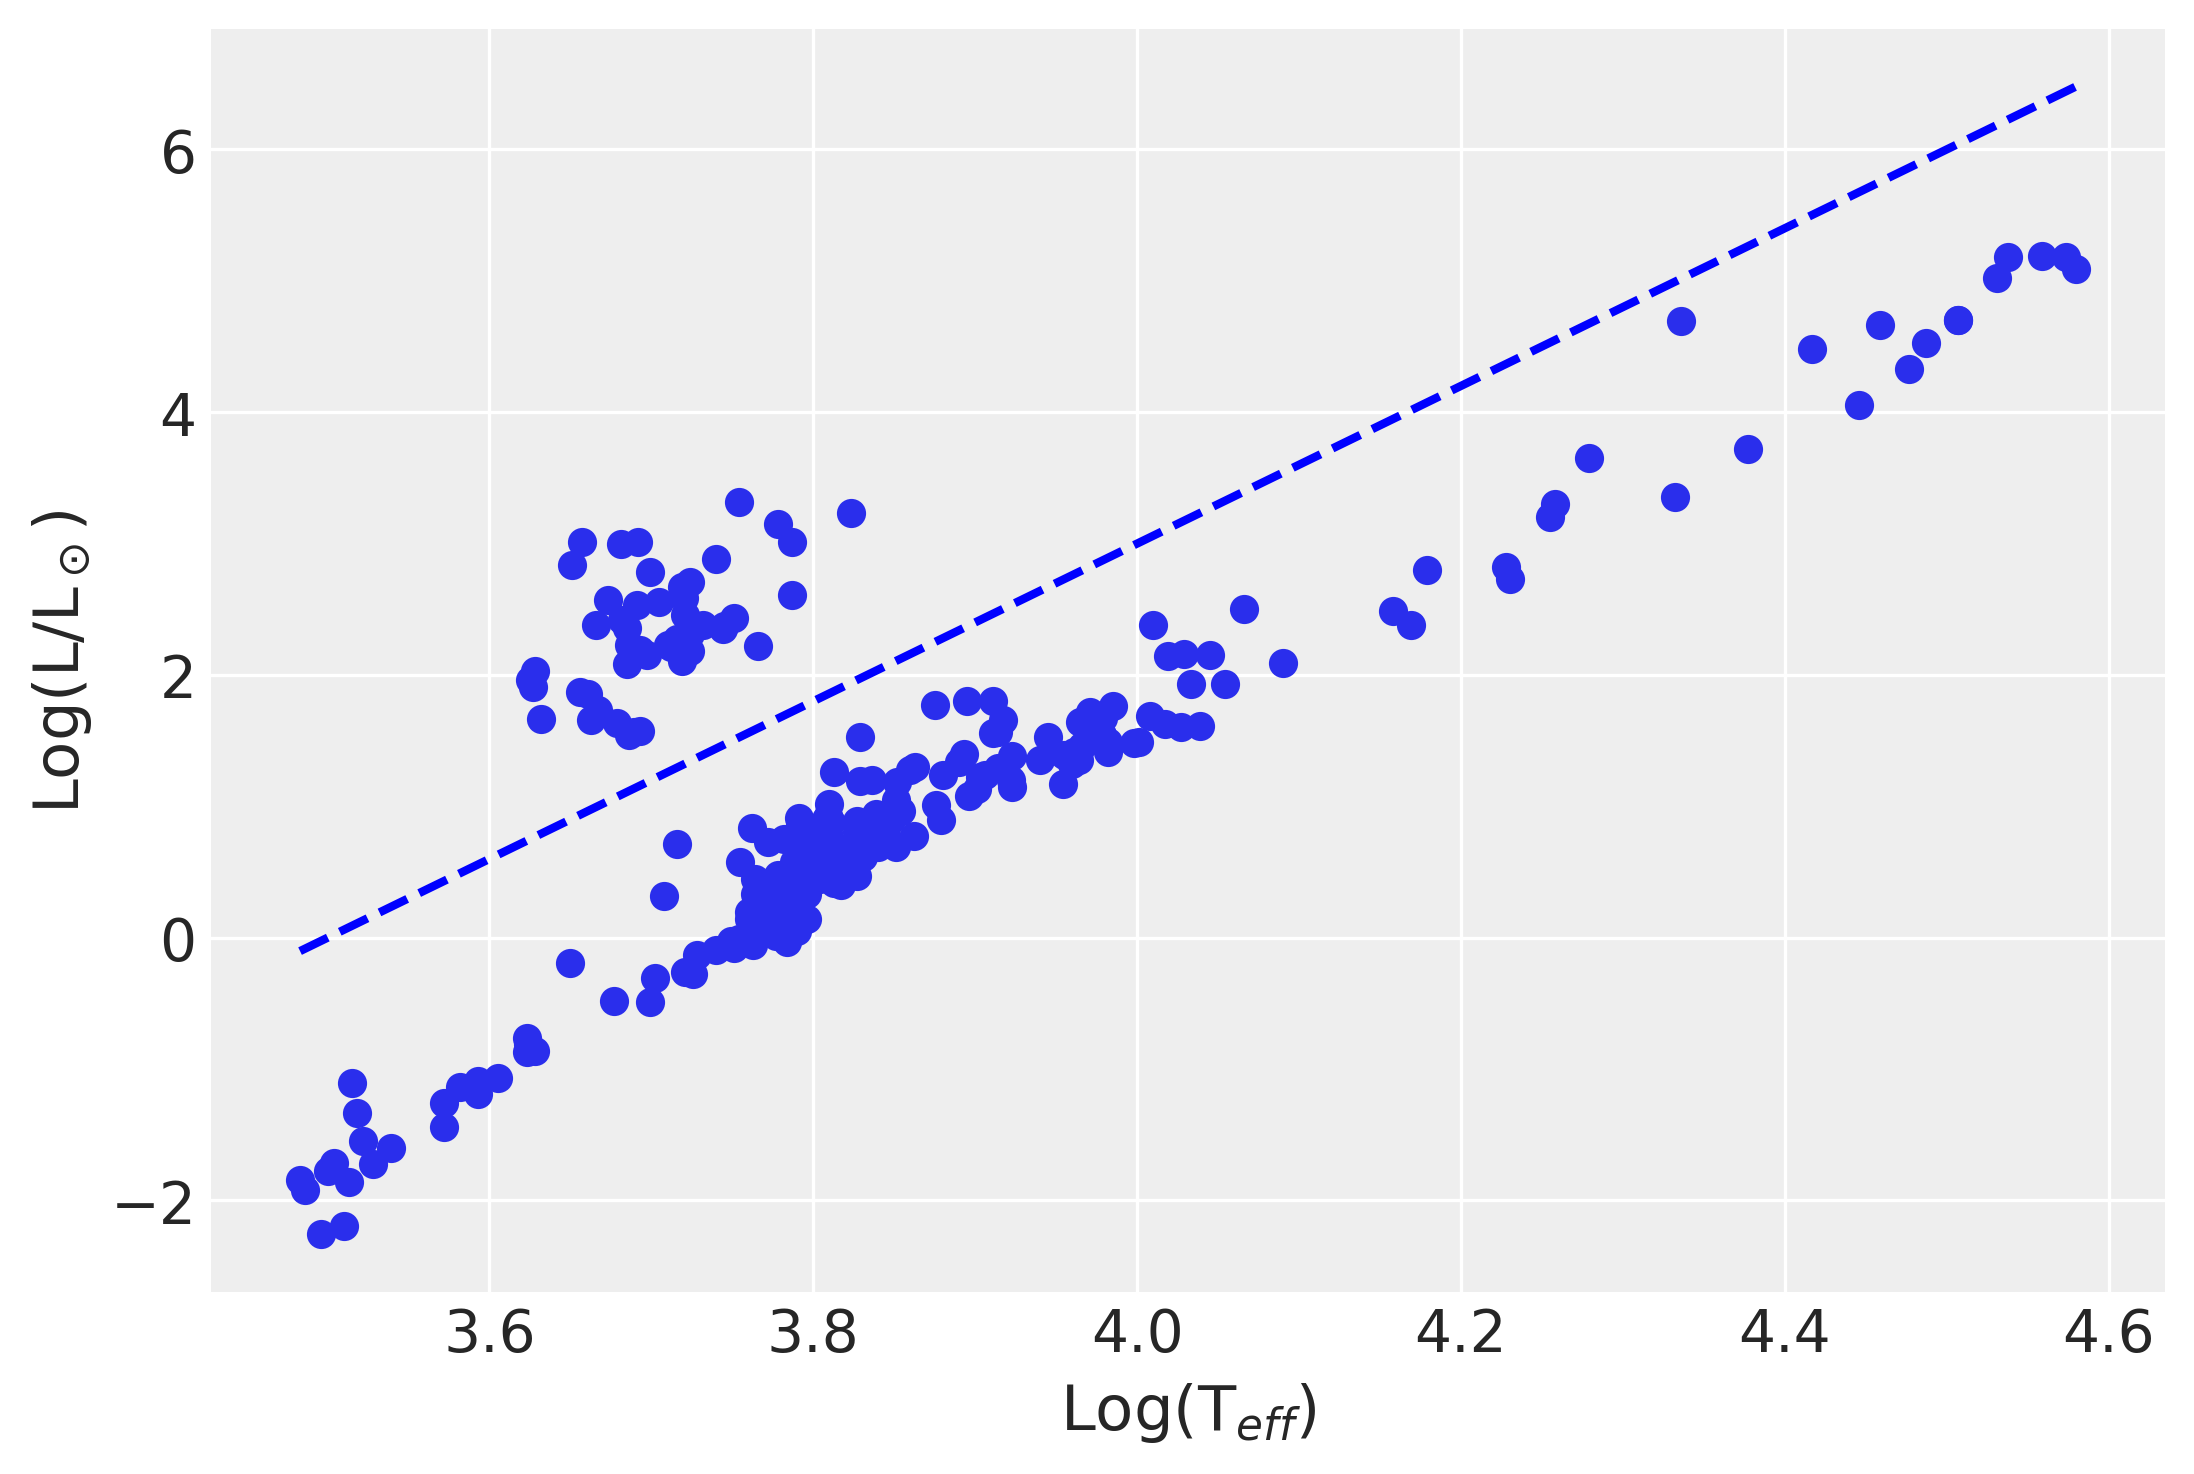

In [389]:
x = np.arange(3.5, 4.6, 0.01)
y = 6*x - 21
plt.scatter(logT1, logL1)
#plt.plot(x, y, color='steelblue', linestyle='--', linewidth=2)
plt.plot(logT1, 6*logT1 -21, color='blue', linestyle='--', linewidth=2)
plt.xlabel('Log(T$_{eff}$)')
plt.ylabel('Log(L/L$_\odot$)')

In [390]:
logT1_cut = logT1[logL1 < (6*logT1-21)]
logL1_cut = logL1[logL1 < (6*logT1-21)]

#filter the errors as well
logT1_err = df['logT1e'][logL1 < (6*logT1-21)]
logL1_err = df['logL1e'][logL1 < (6*logT1-21)]

logT1_err = np.array(logT1_err)
logL1_err = np.array(logL1_err)

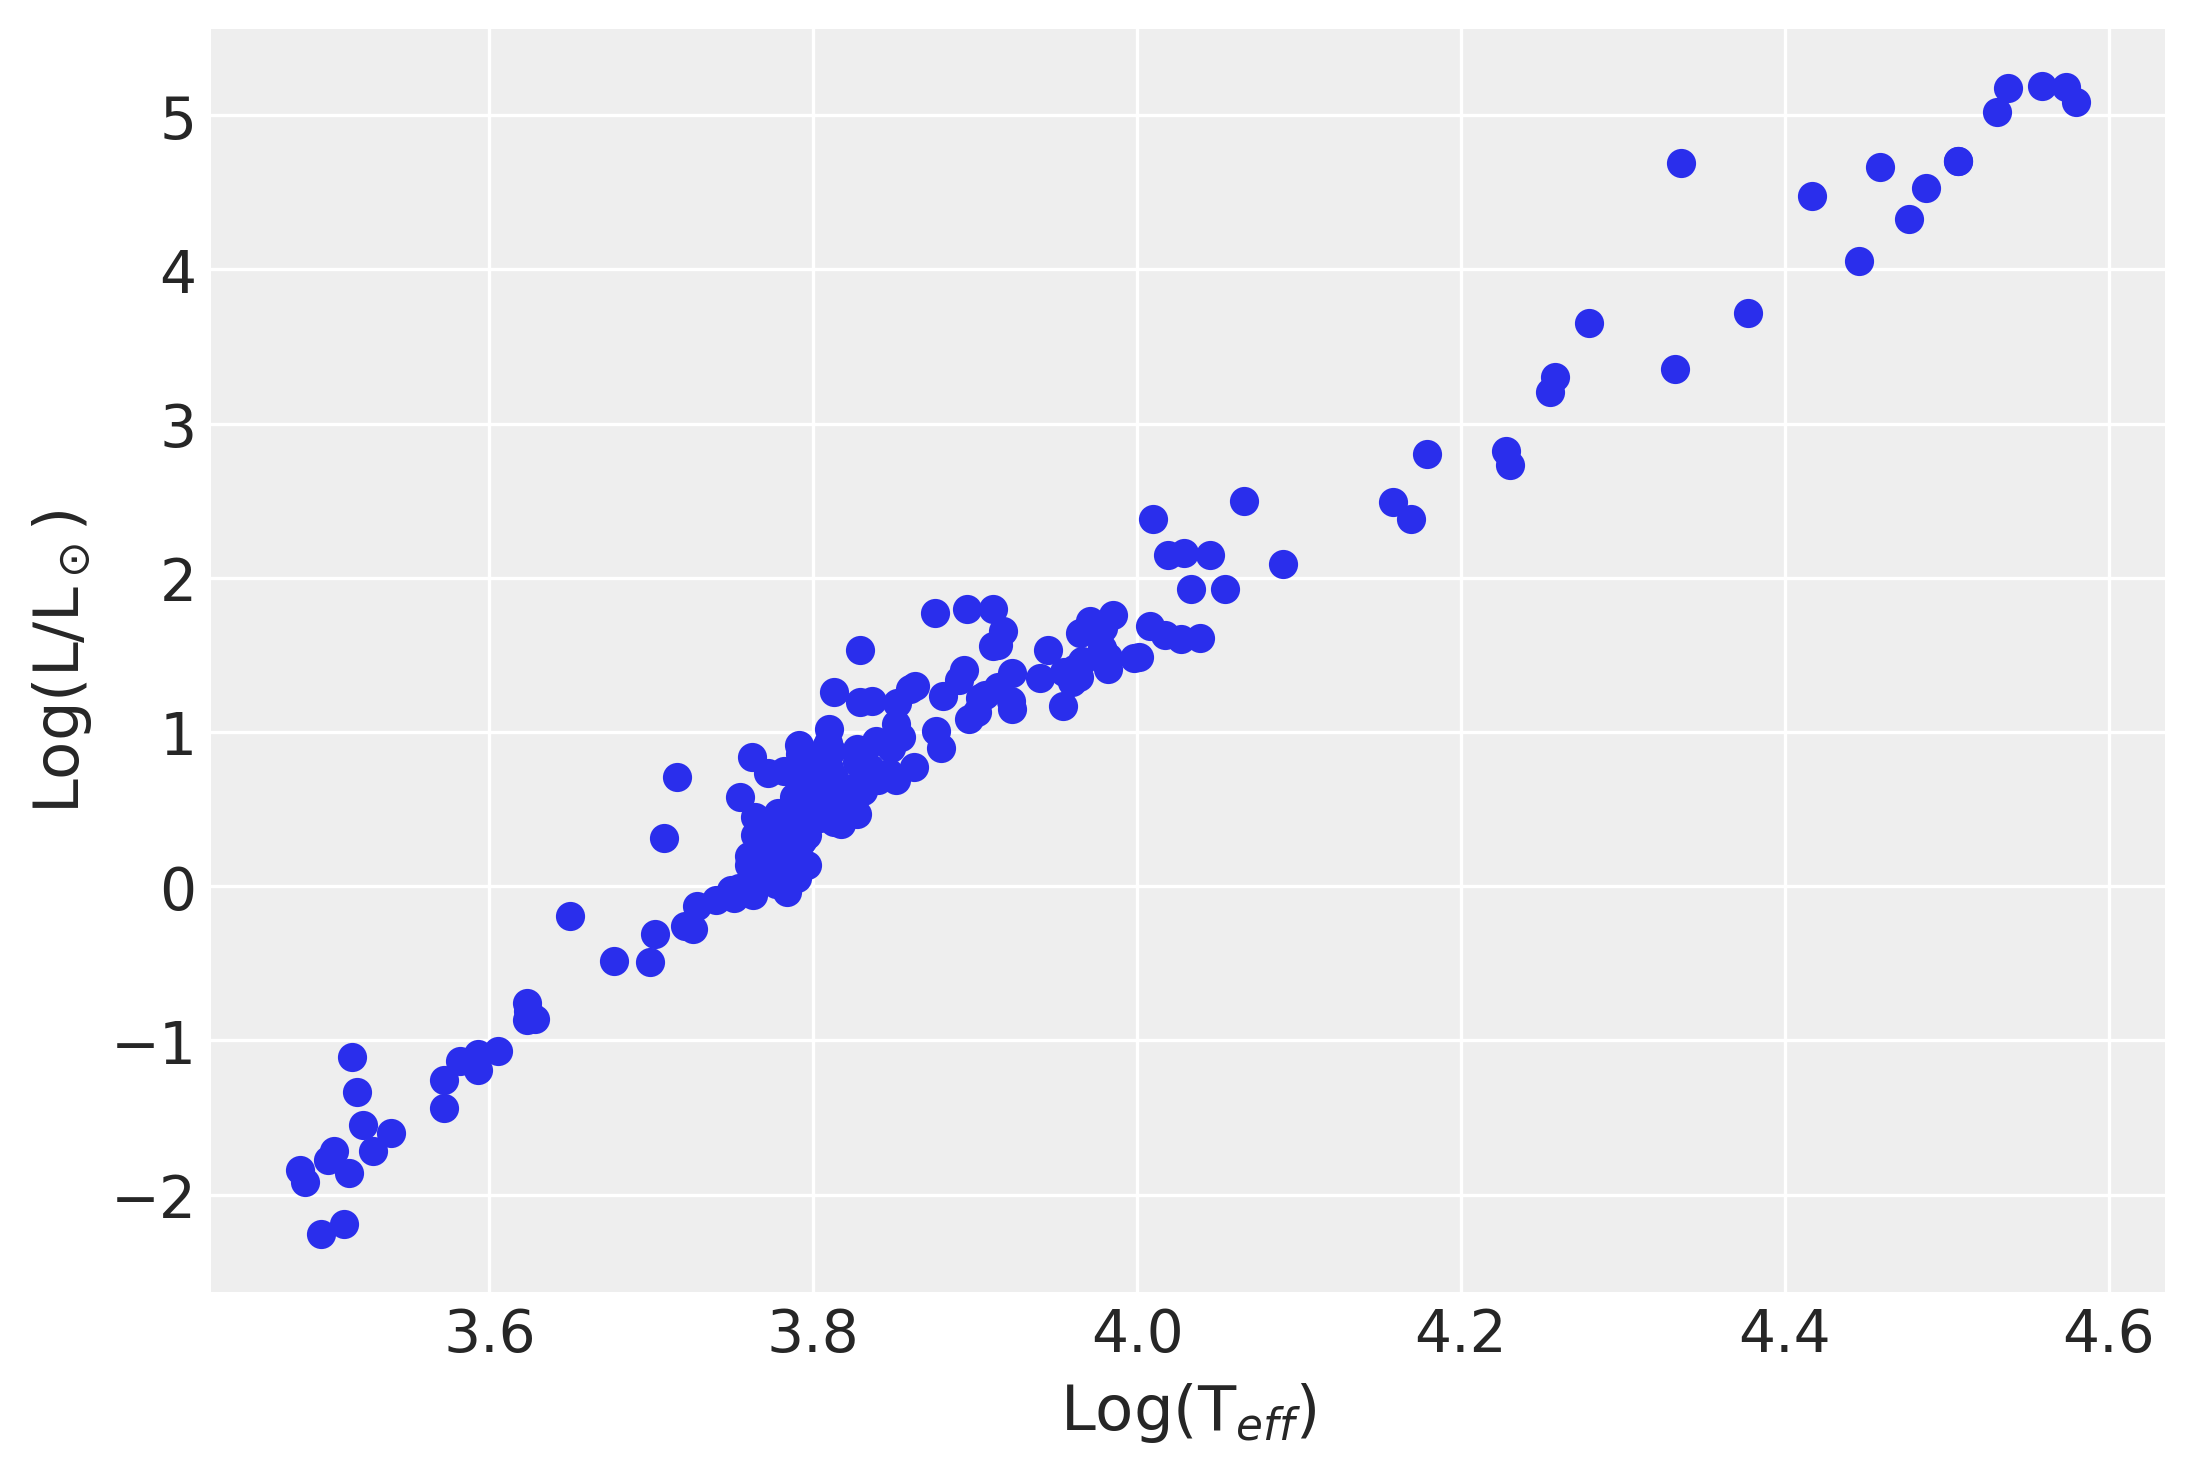

In [391]:
plt.scatter(logT1_cut, logL1_cut)
plt.xlabel('Log(T$_{eff}$)')
plt.ylabel('Log(L/L$_\odot$)')
plt.show()

#error bars on values are so small they hardly show up on the scatter plot
#and they're already transformed in log space so that's not an issue either

In [392]:
import sklearn
from scipy.stats import poisson
from sklearn.linear_model import LinearRegression
import arviz as az
import pymc

In [393]:
from pymc import Model, Normal, Gamma

# Without Known Errors

In [394]:
y = logL1_cut
x1 = logT1_cut

In [395]:
# one that does not include errors
basic_model = Model()

with basic_model:
    # Priors for unknown model parameters
    beta = Normal('beta', mu=0, tau=1./1000, shape=2)
    precision = Gamma('precision', alpha=0.5, beta=0.5)
    # Expected value of outcome
    mu = beta[0] + beta[1]*x1 
    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, tau=precision, observed=y)

In [396]:
from pymc import find_MAP
#import pprint
#pp = pprint.PrettyPrinter(indent=4)
map_estimate = find_MAP(model = basic_model)
map_estimate

{'beta': array([-23.60795949,   6.33604984]),
 'precision_log__': array(2.4255216),
 'precision': array(11.30812616)}

In [397]:
with basic_model:
    start = find_MAP() 
    # draw "draws" posterior samples
    trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=1000)

/var/folders/36/5ssmgg1n0kgbmjfhm188d5br0000gn/T/ipykernel_71634/2962861299.py:4: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


In [398]:
# Get the posterior dataset
posterior = trace.posterior
posterior

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 1000, beta_dim_0: 2)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * beta_dim_0  (beta_dim_0) int64 0 1
Data variables:
    beta        (chain, draw, beta_dim_0) float64 -22.84 6.134 ... -23.43 6.287
    precision   (chain, draw) float64 12.31 12.45 10.11 ... 12.61 12.43 12.44
Attributes:
    created_at:                 2022-11-23T17:57:24.081032
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              40.872390031814575
    tuning_steps:               1000

array([[<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>],
       [<AxesSubplot: title={'center': 'precision'}>,
        <AxesSubplot: title={'center': 'precision'}>]], dtype=object)

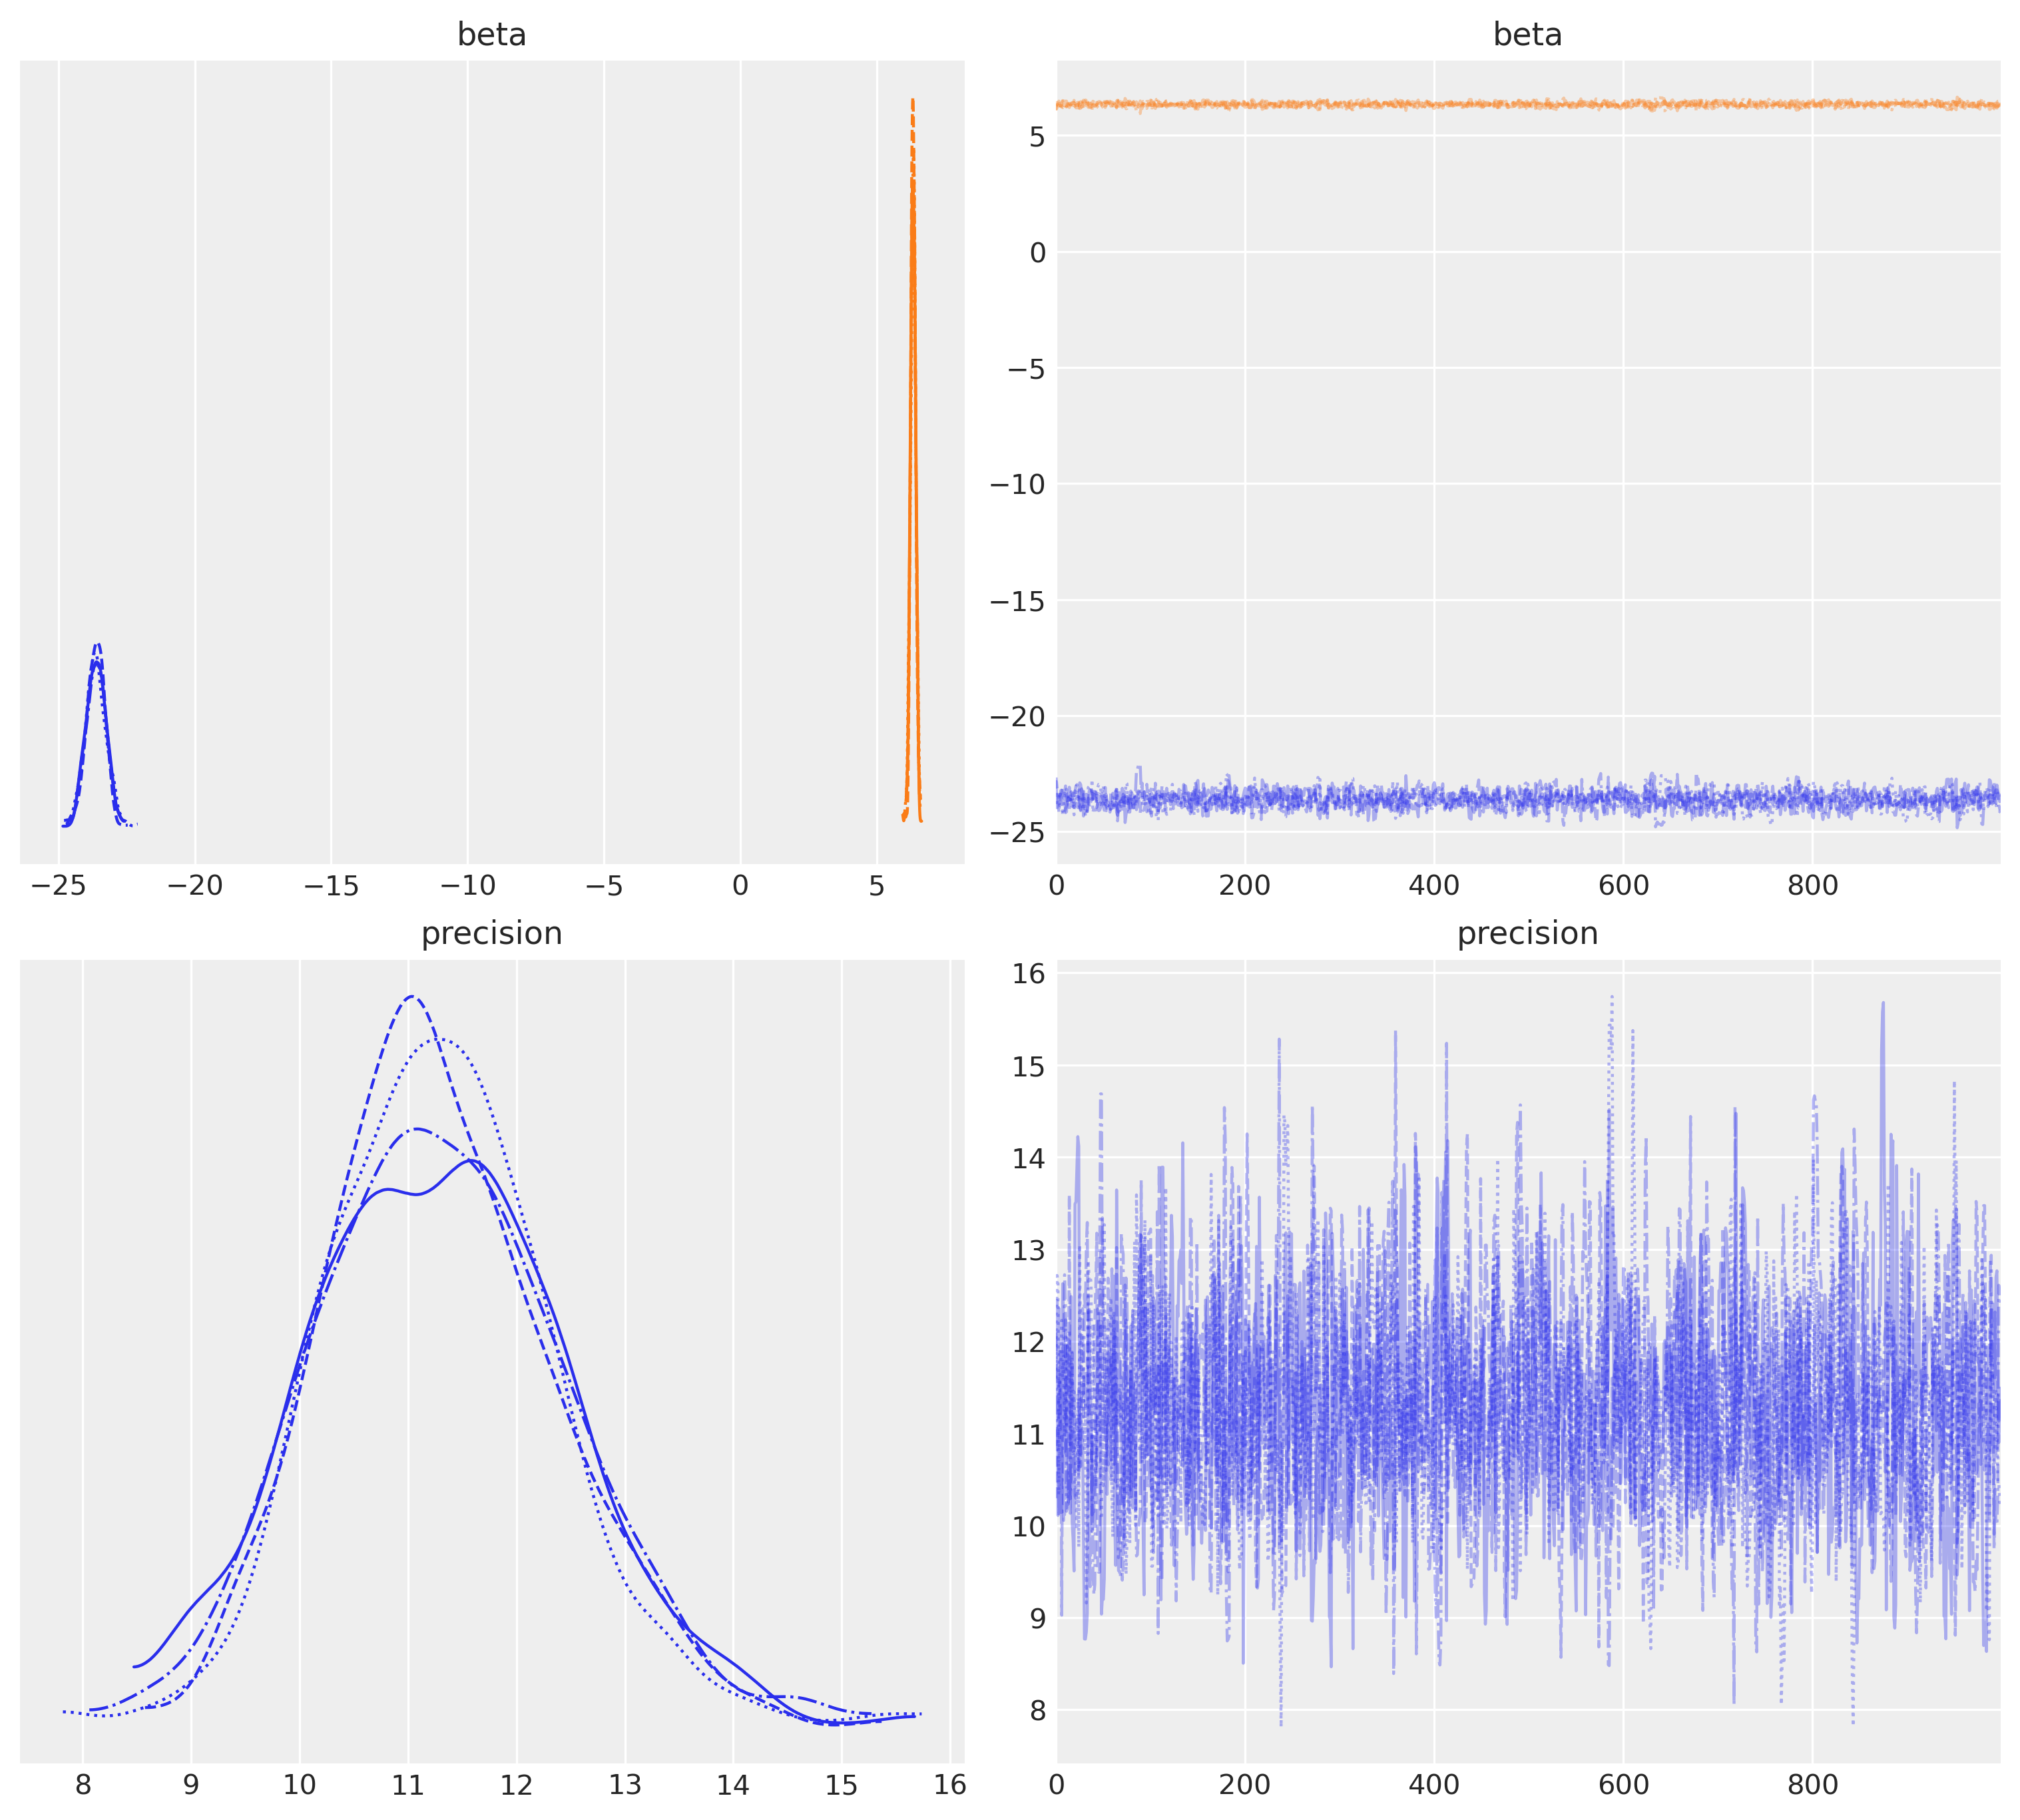

In [399]:
az.plot_trace(trace,figsize=(10, 9))

In [400]:
az.summary(trace, hdi_prob=0.95) # HDI Highest Density Interval 5%

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]   -23.625  0.367   -24.367    -22.959      0.010    0.007    1358.0   
beta[1]     6.341  0.095     6.167      6.529      0.003    0.002    1359.0   
precision  11.302  1.111     9.207     13.519      0.027    0.019    1696.0   

           ess_tail  r_hat  
beta[0]      1250.0    1.0  
beta[1]      1315.0    1.0  
precision    1763.0    1.0

array([<AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>,
       <AxesSubplot: title={'center': 'precision'}>], dtype=object)

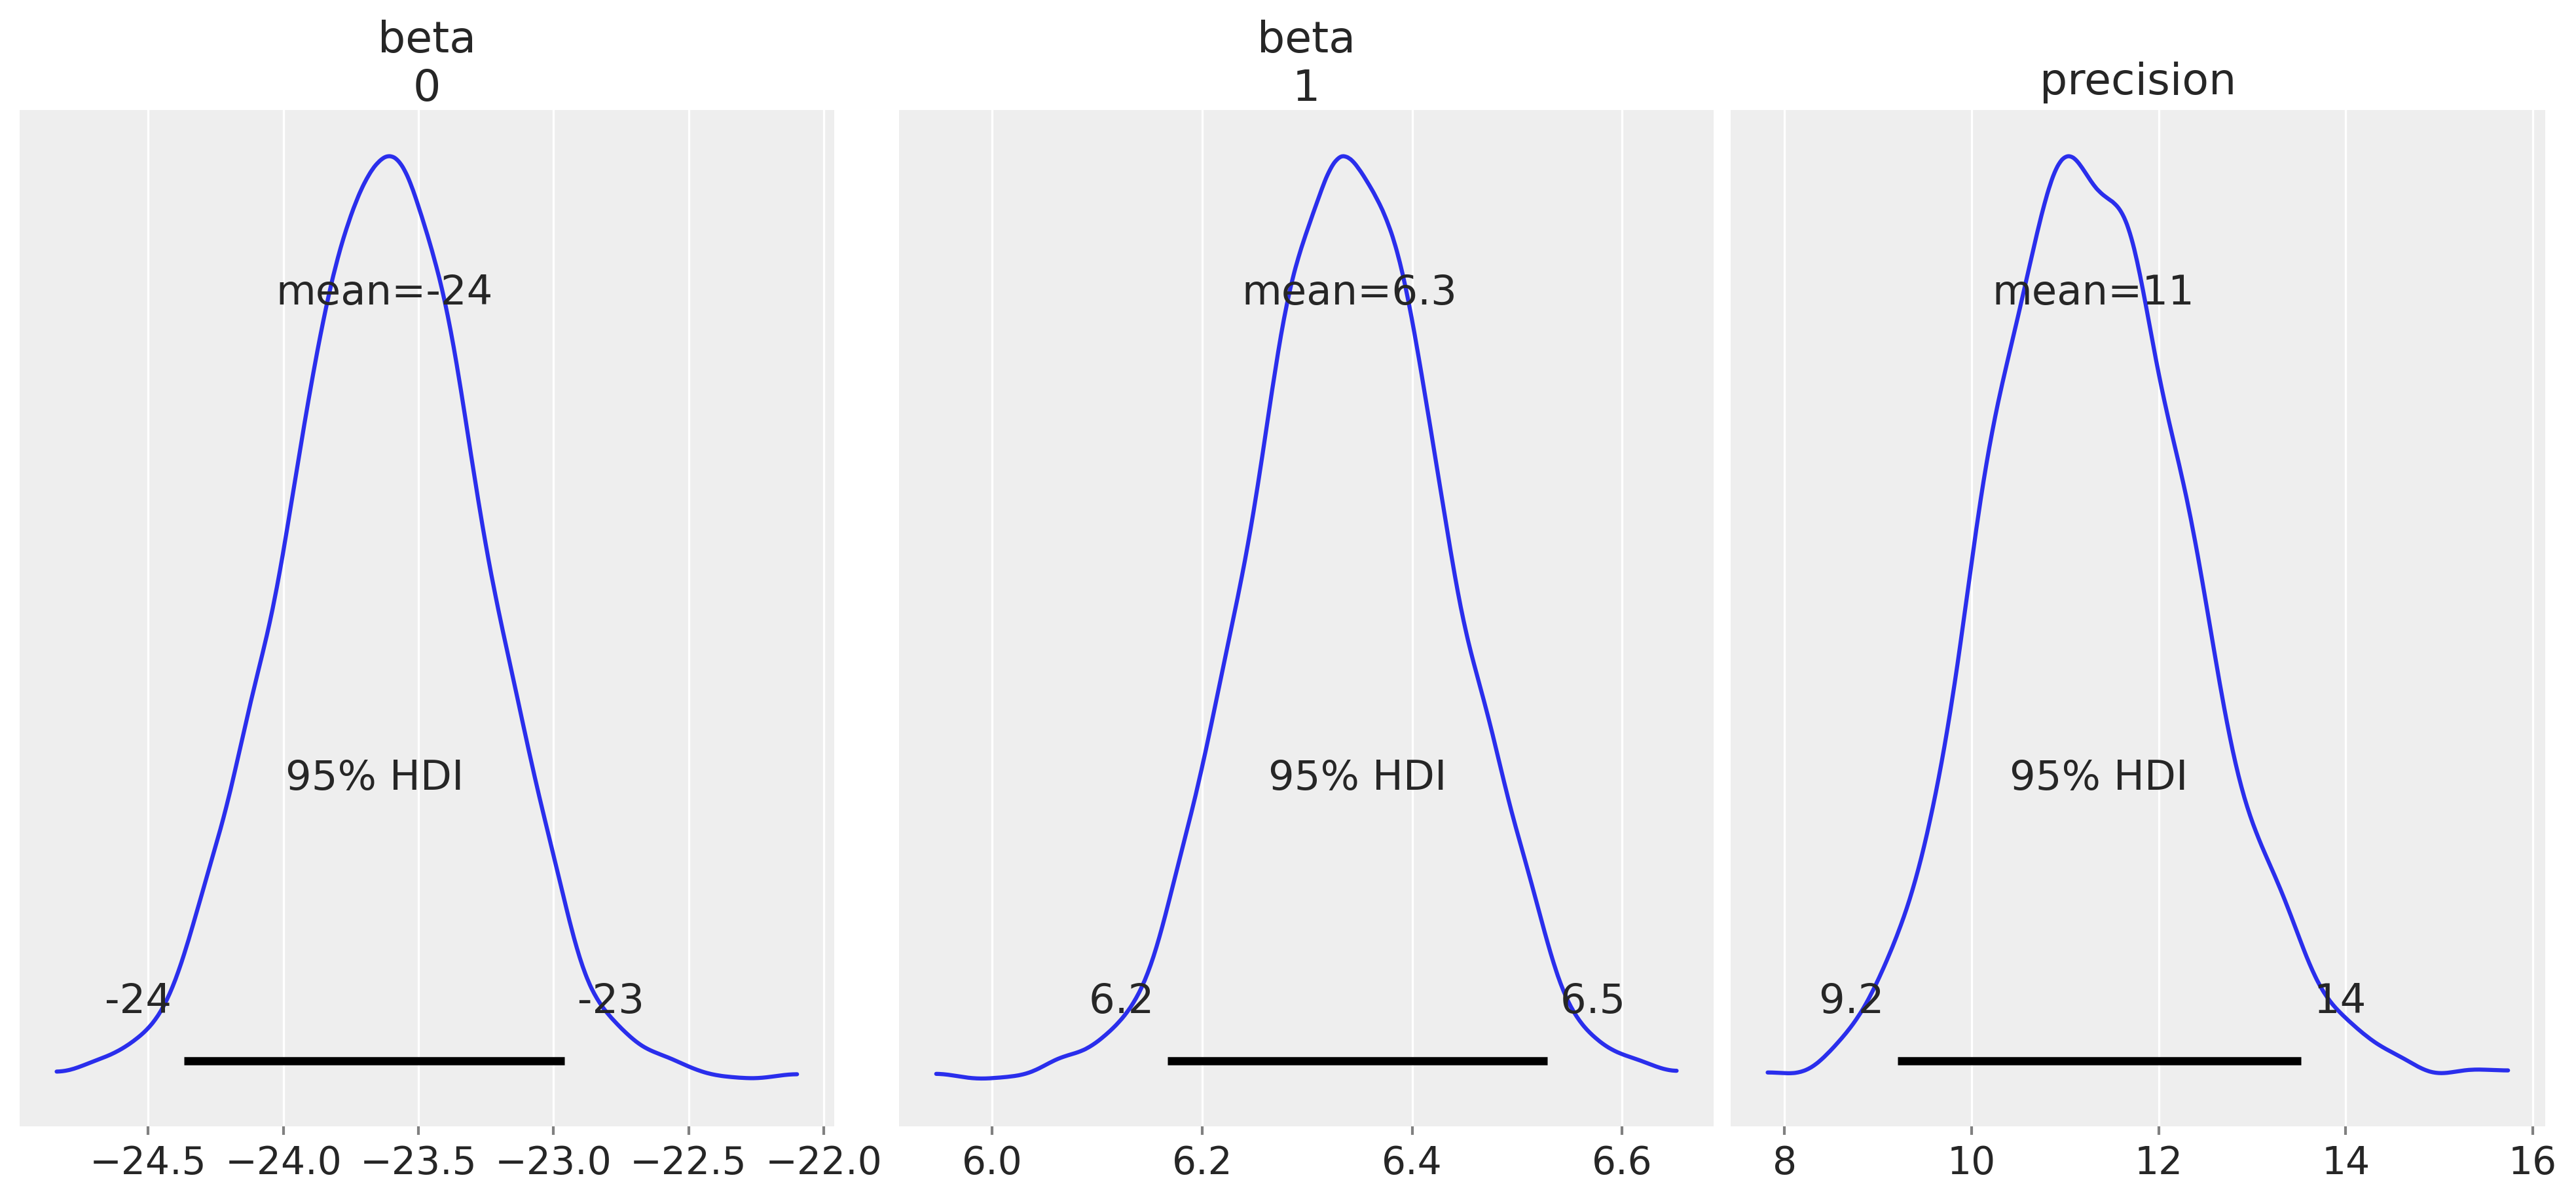

In [401]:
az.plot_posterior(trace, figsize=(13, 6), hdi_prob=0.95)

array([<AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>], dtype=object)

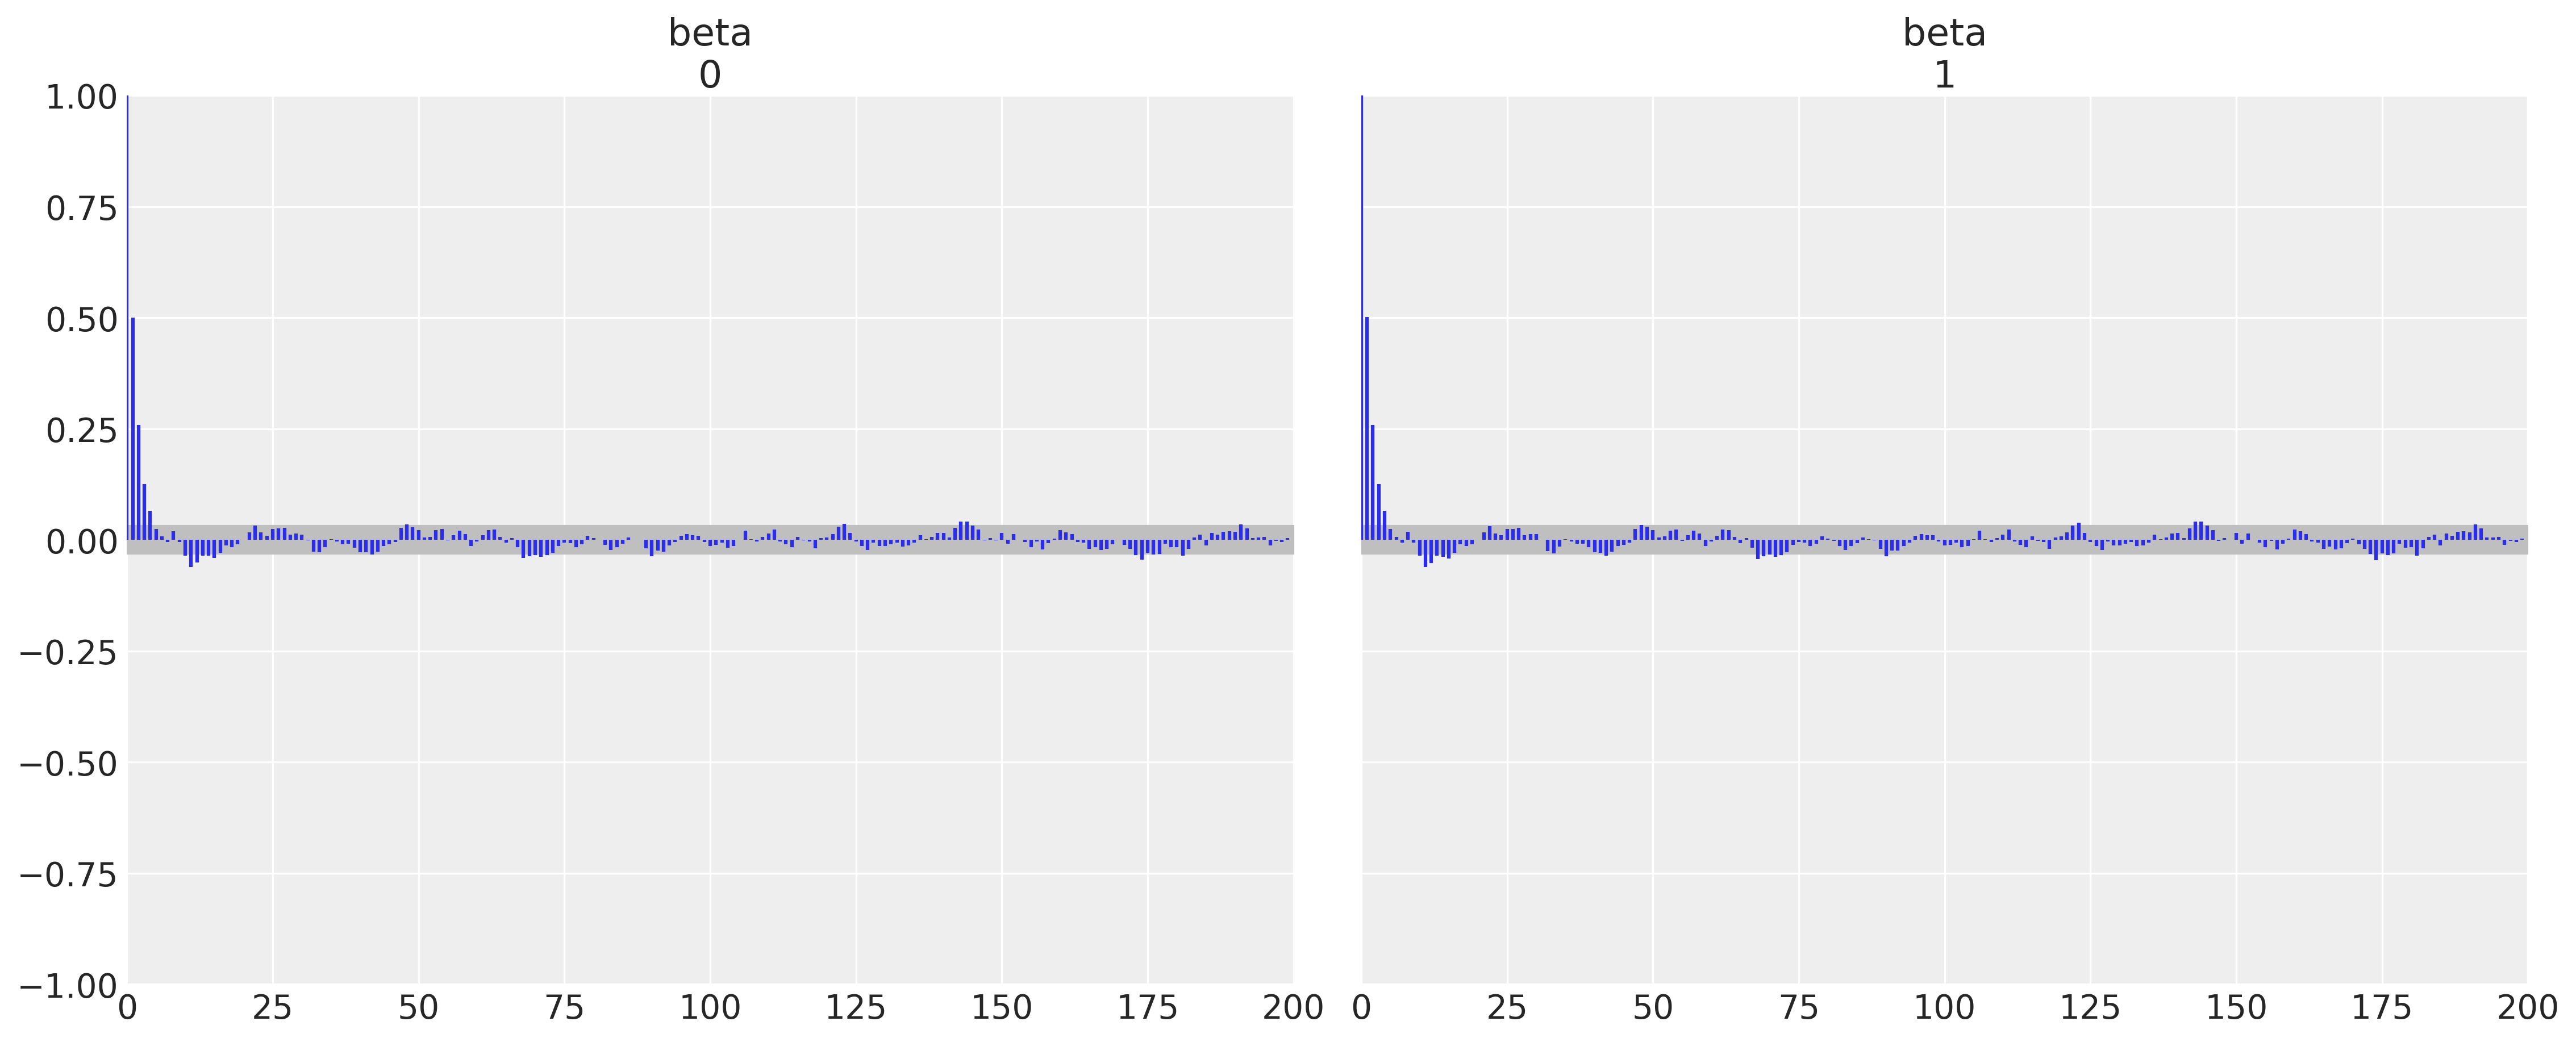

In [402]:
az.plot_autocorr(trace, var_names=['beta'], filter_vars="like",  max_lag=200, combined=True, figsize=(15, 6))

In [403]:
with basic_model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

trace.posterior_predictive

Sampling: [Y_obs]


<xarray.Dataset>
Dimensions:      (chain: 4, draw: 1000, Y_obs_dim_2: 212)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * Y_obs_dim_2  (Y_obs_dim_2) int64 0 1 2 3 4 5 6 ... 206 207 208 209 210 211
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_2) float64 -0.9995 -1.667 ... 5.466
Attributes:
    created_at:                 2022-11-23T17:57:43.894946
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0

<AxesSubplot: xlabel='Y_obs / Y_obs'>

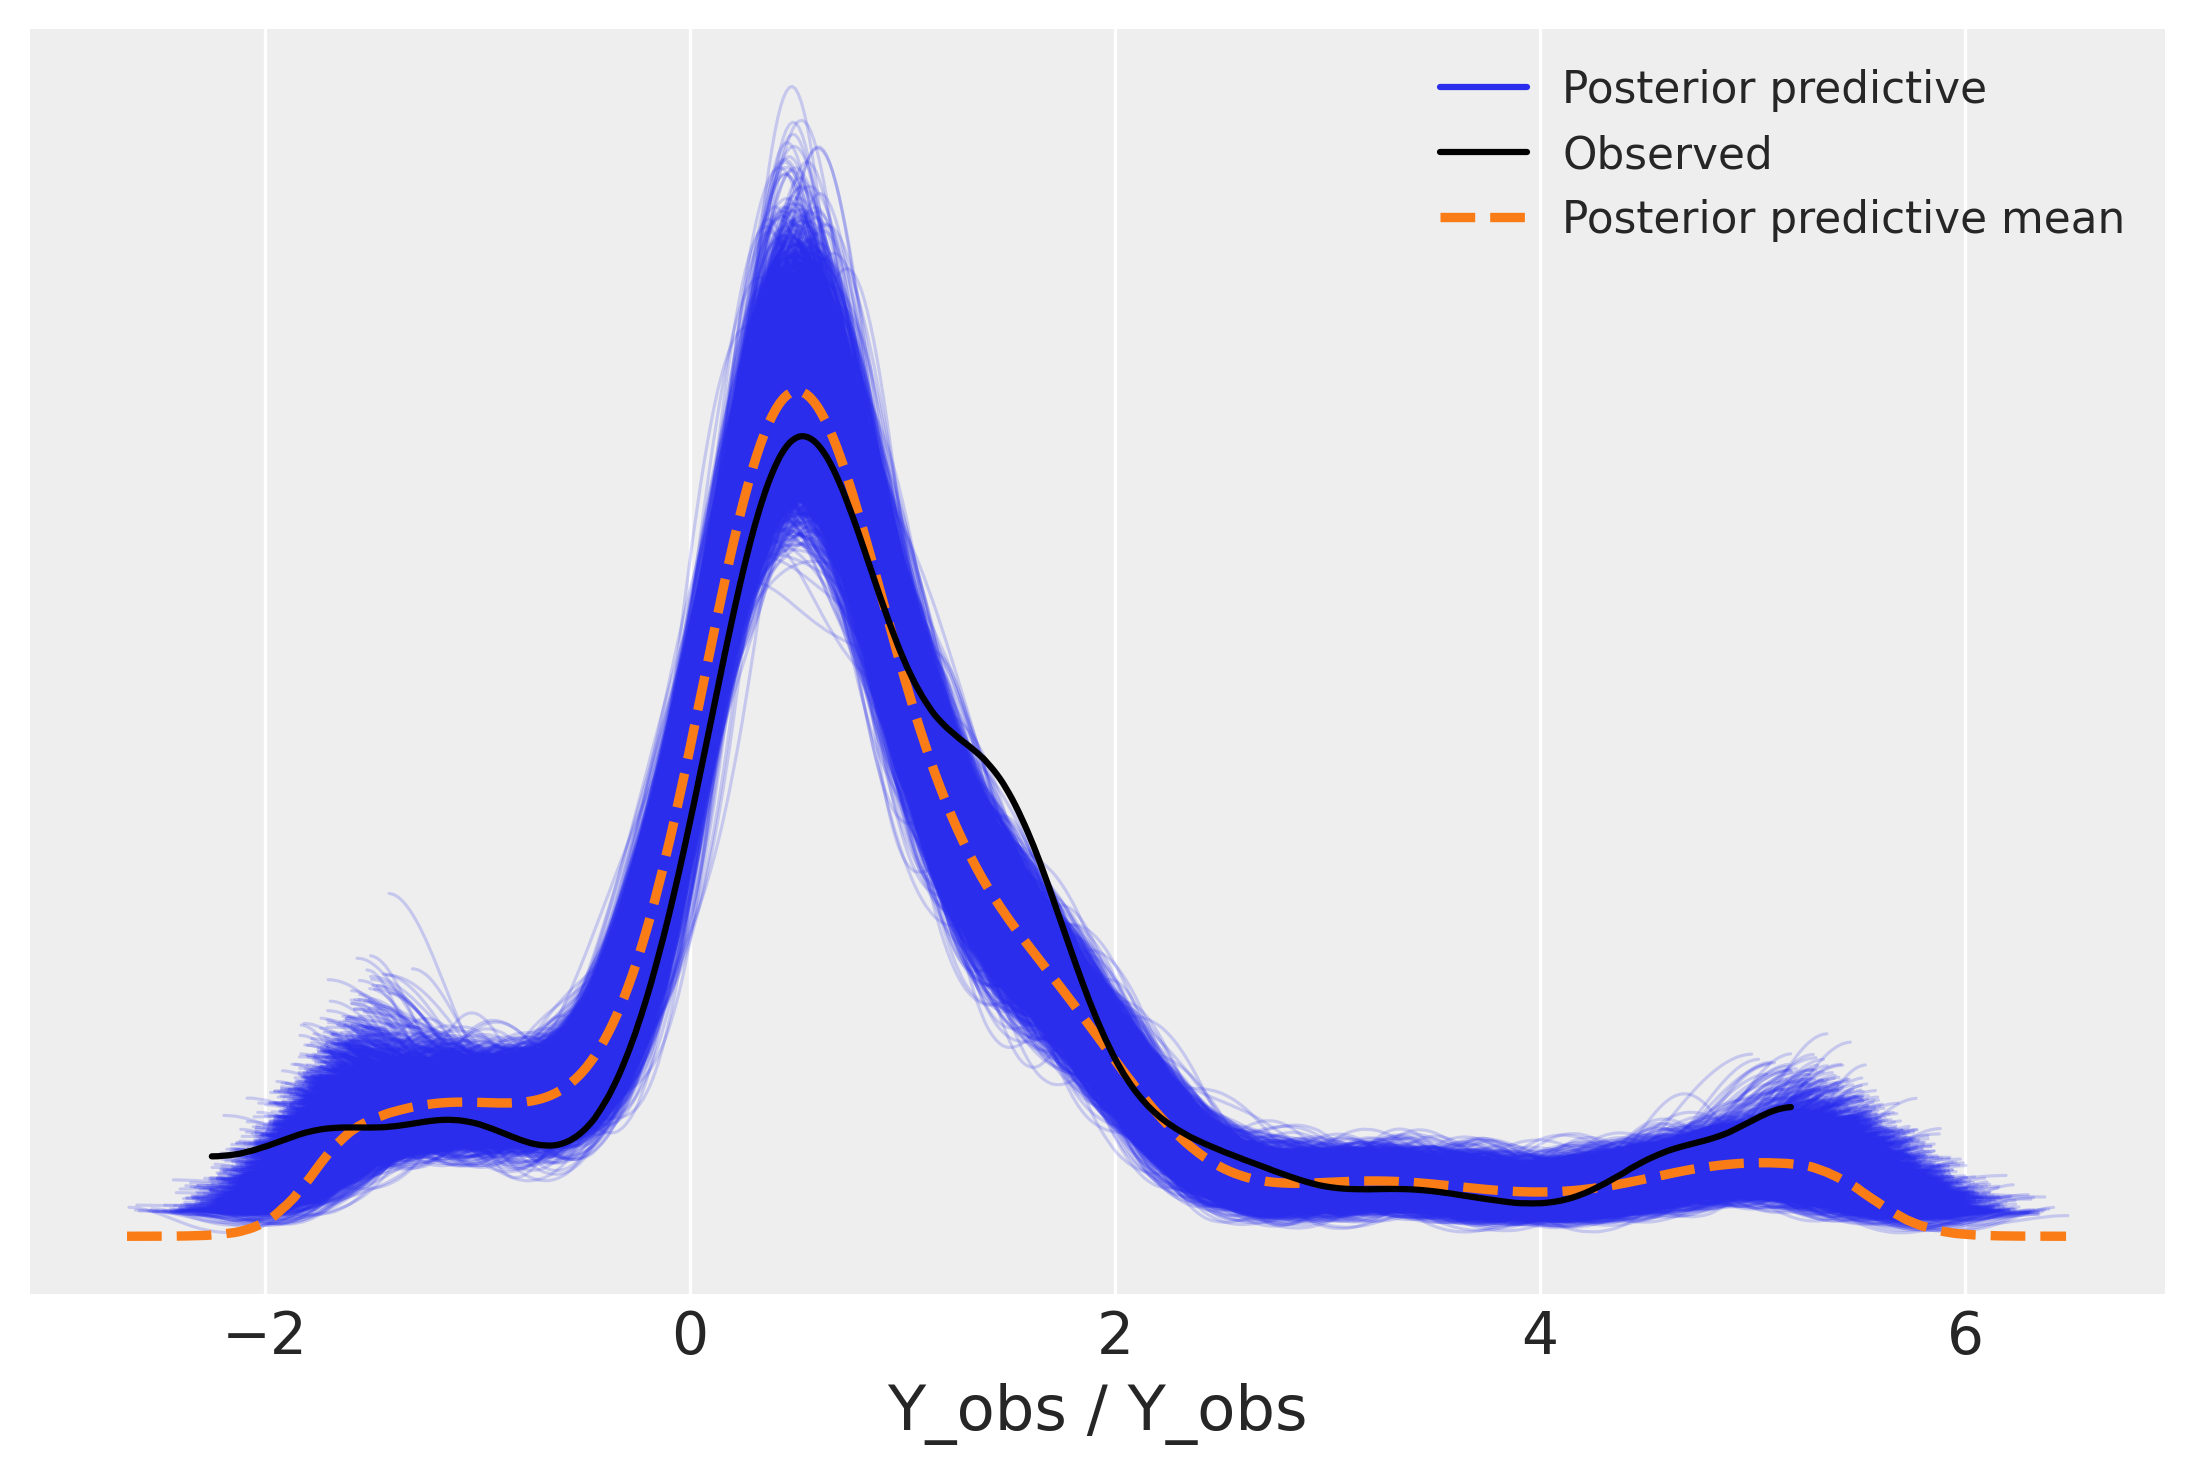

In [404]:
az.plot_ppc(trace)

In [405]:
az.summary(trace.posterior_predictive, hdi_prob = 0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
Y_obs[0]   -1.541  0.295    -2.128     -0.962      0.005    0.003    4083.0   
Y_obs[1]   -1.454  0.303    -2.023     -0.840      0.005    0.003    3849.0   
Y_obs[2]   -1.374  0.293    -1.962     -0.813      0.005    0.003    3915.0   
Y_obs[3]   -1.342  0.297    -1.956     -0.792      0.005    0.003    4040.0   
Y_obs[4]   -1.526  0.301    -2.121     -0.961      0.005    0.003    3982.0   
...           ...    ...       ...        ...        ...      ...       ...   
Y_obs[207]  5.379  0.310     4.758      5.967      0.005    0.004    3487.0   
Y_obs[208]  5.109  0.311     4.485      5.689      0.005    0.004    3685.0   
Y_obs[209]  5.159  0.308     4.537      5.746      0.005    0.004    3630.0   
Y_obs[210]  5.278  0.310     4.715      5.935      0.005    0.004    3564.0   
Y_obs[211]  5.411  0.311     4.825      6.047      0.005    0.004    3321.0   

            ess_tail  r_hat  
Y_obs[0]      3956.0    1.0  
Y_obs[1]      3837.0    1.0  
Y_obs[2]      4015.0    1.0  
Y_obs[3]      4100.0    1.0  
Y_obs[4]      3497.0    1.0  
...              ...    ...  
Y_obs[207]    3870.0    1.0  
Y_obs[208]    3531.0    1.0  
Y_obs[209]    3709.0    1.0  
Y_obs[210]    3455.0    1.0  
Y_obs[211]    3520.0    1.0  

[212 rows x 9 columns]

# With Known Errors

In [430]:
a = logL1_err ** (-2)
b = logT1_err ** (-2)
y_obs = y
x_obs = x1
c = d = 1e-3
e = f = 1

In [431]:
basic_model = Model()

with basic_model:
    # Priors for unknown model parameters
    tau = Gamma('tau', alpha=e, beta=f)
    X1 = Normal("X1", mu=0, tau=tau, shape=212)
    beta = Normal('beta', mu=0, tau=d, shape=2)
    Y = Normal("Y", mu=beta[0] + beta[1]*X1, tau=tau)
    # Likelihood (sampling distribution) of observations
    Y_star = Normal('Y_star', mu=Y, tau=a, observed=y_obs)
    X1_star = Normal('X_star', mu=X1, tau=b, observed=x_obs)

In [432]:
from pymc import find_MAP
import pprint
pp = pprint.PrettyPrinter(indent=4)
map_estimate = find_MAP(model = basic_model) #*********
pp.pprint(map_estimate)


{   'X1': array([3.48291525, 3.49588694, 3.50997121, 3.5149581 , 3.48555001,
       3.51287438, 3.52797872, 3.49967497, 3.50383843, 3.53861065,
       3.5179958 , 3.57196893, 3.52188823, 3.59290842, 3.57190079,
       3.60497356, 3.58192145, 3.59287021, 3.62793178, 3.6237341 ,
       3.79598099, 3.62293419, 3.69877701, 3.78393349, 3.78996059,
       3.62277881, 3.78495937, 3.77198383, 3.79298465, 3.7869458 ,
       3.67687998, 3.78895802, 3.72581849, 3.77999481, 3.77499563,
       3.74892302, 3.72797747, 3.70189732, 3.75996441, 3.72084523,
       3.76394732, 3.73995906, 3.75095593, 3.75395833, 3.77696257,
       3.64996842, 3.78699591, 3.75993853, 3.76292547, 3.77195311,
       3.77097431, 3.77296675, 3.76399333, 3.77495669, 3.76697783,
       3.77298673, 3.78198332, 3.77097757, 3.78796918, 3.77794112,
       3.77096696, 3.77498873, 3.80099726, 3.7809871 , 3.80399131,
       3.78296937, 3.77799051, 3.79293204, 3.79199779, 3.76389483,
       3.78399549, 3.79596197, 3.79197355, 3.814863

In [433]:
trace.posterior.dims

Frozen({'chain': 4, 'draw': 1000, 'X1_dim_0': 212, 'beta_dim_0': 2, 'Y_dim_0': 212})

In [434]:
# Initialize random number generator
RANDOM_SEED = 5731
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

print(f"Running on PyMC v{pm.__version__}")

with basic_model: #*********
    start = find_MAP()  #**********
    #step = pm.Metropolis()
    # draw 1000 posterior samples
    trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=1000) # step=step

# These general samplers take too long.
# The dimension is too high due to X and Y random vectors.
# Suggest using the Gibbs samplers in R with code provided in LinearRegressionME.pdf page 11. 

Running on PyMC v4.3.0


/var/folders/36/5ssmgg1n0kgbmjfhm188d5br0000gn/T/ipykernel_71634/4118142262.py:13: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(cores=4, chains=4, start=start, return_inferencedata=True, draws=1000) # step=step
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, X1, beta, Y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


In [435]:
# Get the posterior dataset
posterior = trace.posterior
posterior

<xarray.Dataset>
Dimensions:     (chain: 4, draw: 1000, X1_dim_0: 212, beta_dim_0: 2,
                 Y_dim_0: 212)
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * X1_dim_0    (X1_dim_0) int64 0 1 2 3 4 5 6 7 ... 205 206 207 208 209 210 211
  * beta_dim_0  (beta_dim_0) int64 0 1
  * Y_dim_0     (Y_dim_0) int64 0 1 2 3 4 5 6 7 ... 205 206 207 208 209 210 211
Data variables:
    X1          (chain, draw, X1_dim_0) float64 3.482 3.48 3.505 ... 4.524 4.567
    beta        (chain, draw, beta_dim_0) float64 -17.83 4.875 ... -23.24 6.339
    Y           (chain, draw, Y_dim_0) float64 -1.868 -2.263 ... 5.125 5.084
    tau         (chain, draw) float64 0.1287 0.1446 0.1255 ... 0.129 0.1438
Attributes:
    created_at:                 2022-11-23T18:28:42.192197
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              46.25072002410889
    tuning_steps:               1000

array([[<AxesSubplot: title={'center': 'tau'}>,
        <AxesSubplot: title={'center': 'tau'}>]], dtype=object)

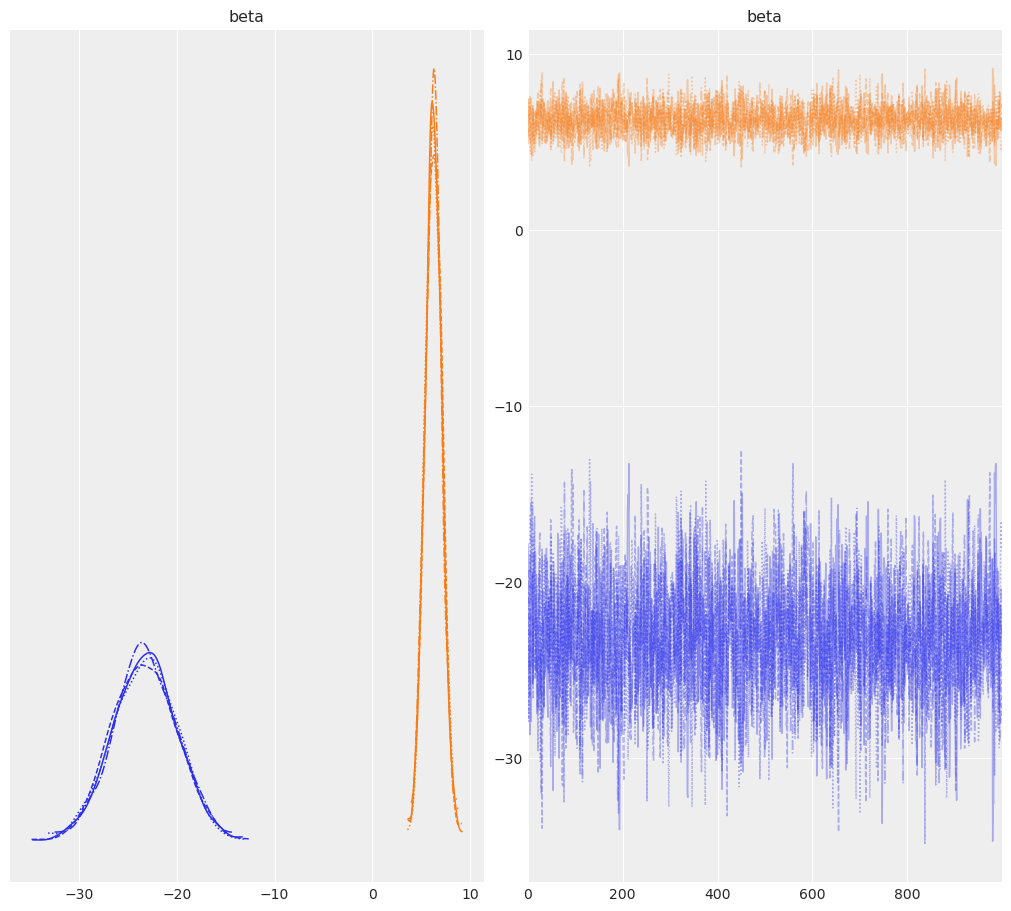

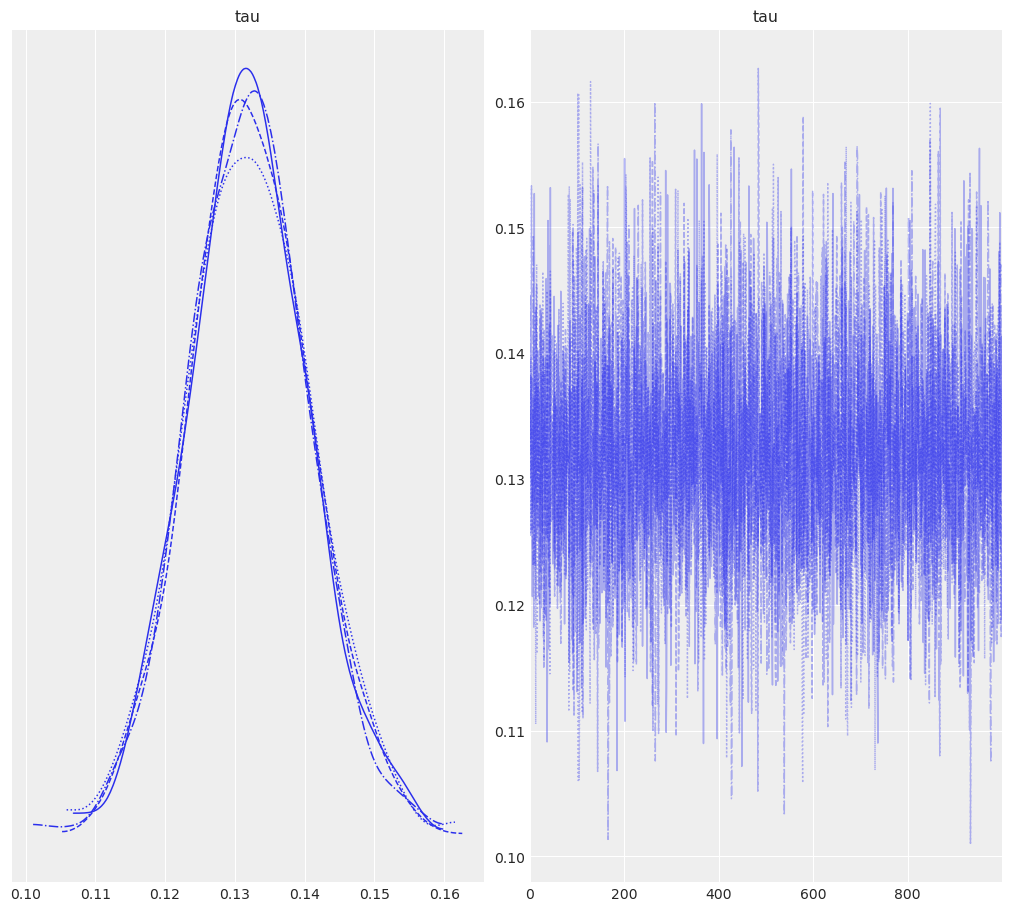

In [436]:
az.plot_trace(trace.posterior["beta"],figsize=(10, 9))
az.plot_trace(trace.posterior["tau"],figsize=(10, 9))

In [437]:
az.summary(trace.posterior[["beta","tau"]], hdi_prob=0.95)

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta[0] -23.288  3.354   -29.979    -16.787      0.066    0.047    2581.0   
beta[1]   6.252  0.865     4.629      8.020      0.017    0.012    2577.0   
tau       0.132  0.009     0.115      0.150      0.000    0.000    6151.0   

         ess_tail  r_hat  
beta[0]    2616.0    1.0  
beta[1]    2602.0    1.0  
tau        2882.0    1.0

array([<AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>,
       <AxesSubplot: title={'center': 'tau'}>], dtype=object)

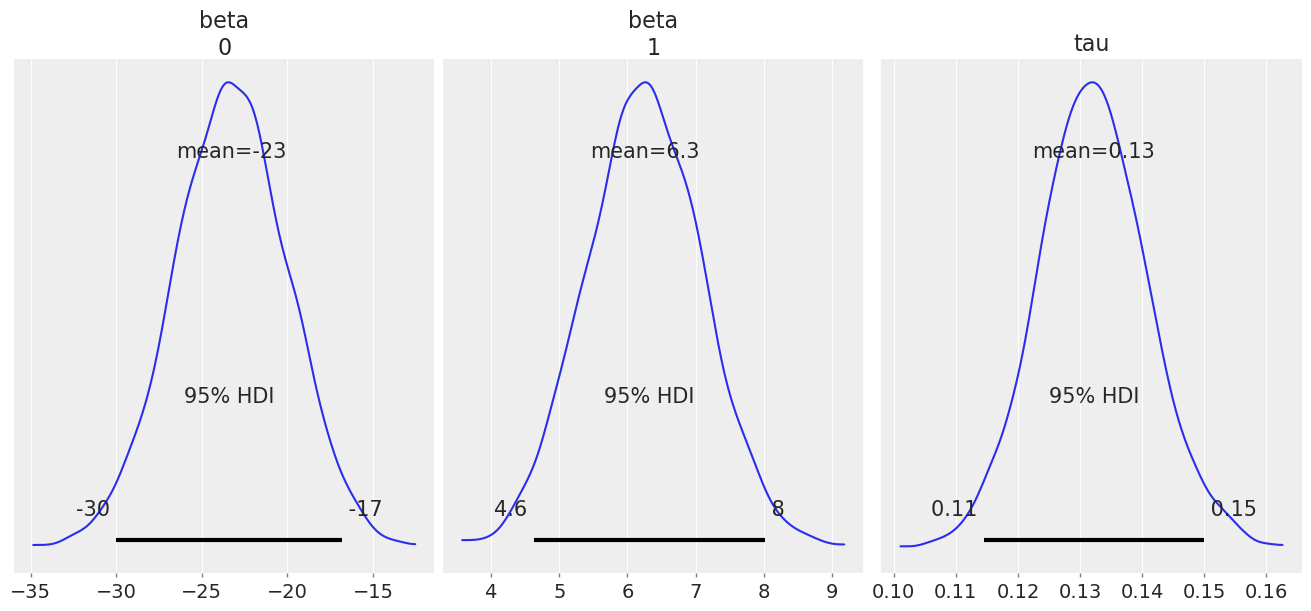

In [438]:
az.plot_posterior(trace.posterior[["beta","tau"]],figsize=(13, 6), hdi_prob=0.95)

In [439]:
print(az.ess(trace,var_names=['beta']))

<xarray.Dataset>
Dimensions:     (beta_dim_0: 2)
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 0 1
Data variables:
    beta        (beta_dim_0) float64 2.581e+03 2.577e+03


array([<AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>], dtype=object)

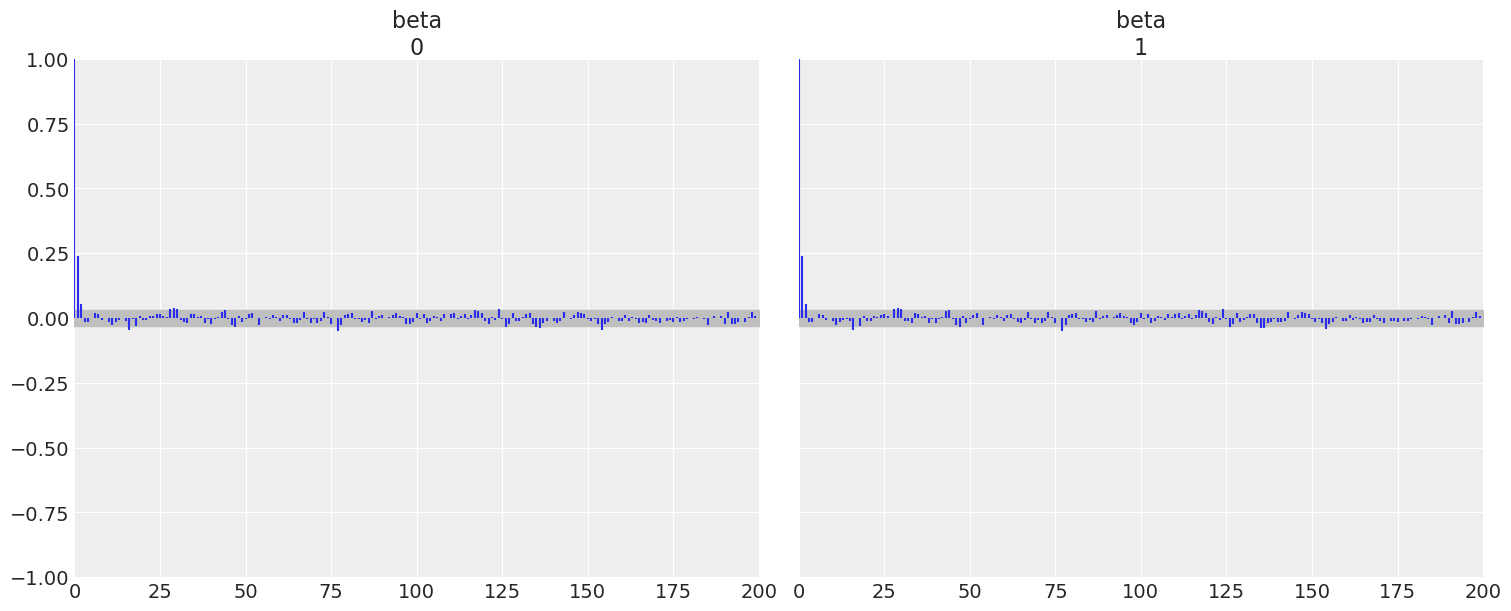

In [440]:
az.plot_autocorr(trace, var_names=['beta'], filter_vars="like",  max_lag=200,combined=True,figsize=(15, 6))


In [441]:
# Posterior Predictive Sampling
with basic_model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

trace.posterior_predictive

Sampling: [X_star, Y_star]


<xarray.Dataset>
Dimensions:       (chain: 4, draw: 1000, Y_star_dim_2: 212, X_star_dim_2: 212)
Coordinates:
  * chain         (chain) int64 0 1 2 3
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * Y_star_dim_2  (Y_star_dim_2) int64 0 1 2 3 4 5 6 ... 206 207 208 209 210 211
  * X_star_dim_2  (X_star_dim_2) int64 0 1 2 3 4 5 6 ... 206 207 208 209 210 211
Data variables:
    Y_star        (chain, draw, Y_star_dim_2) float64 -1.794 -2.229 ... 5.057
    X_star        (chain, draw, X_star_dim_2) float64 3.477 3.49 ... 4.496 4.593
Attributes:
    created_at:                 2022-11-23T18:28:48.102742
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0

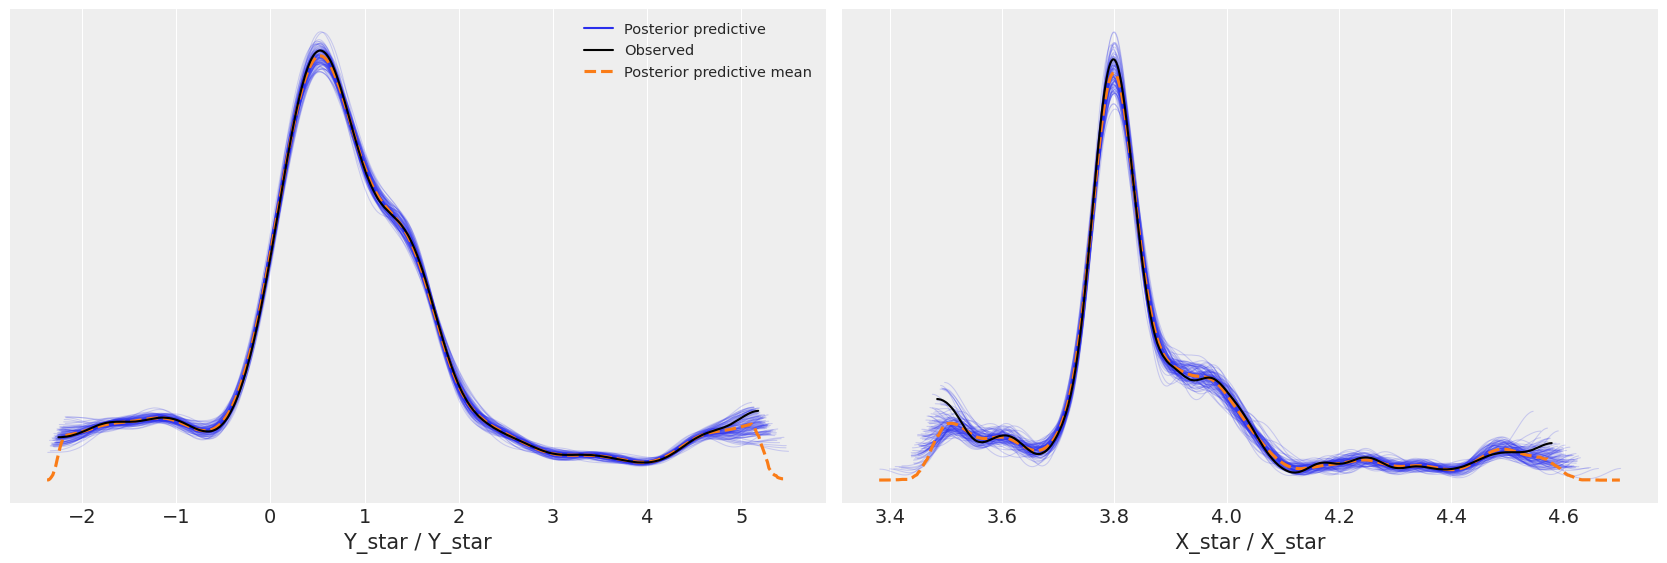

In [442]:
az.plot_ppc(trace, num_pp_samples=100);

# Sensitivity Analysis 

/var/folders/36/5ssmgg1n0kgbmjfhm188d5br0000gn/T/ipykernel_71634/152206405.py:26: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace_set1 = pm.sample(cores=4, chains=4, start=start_set1, return_inferencedata=True, draws=1000) # step=step
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, X1, beta, Y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
Sampling: [X_star, Y_star]


array([<AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>,
       <AxesSubplot: title={'center': 'tau'}>], dtype=object)

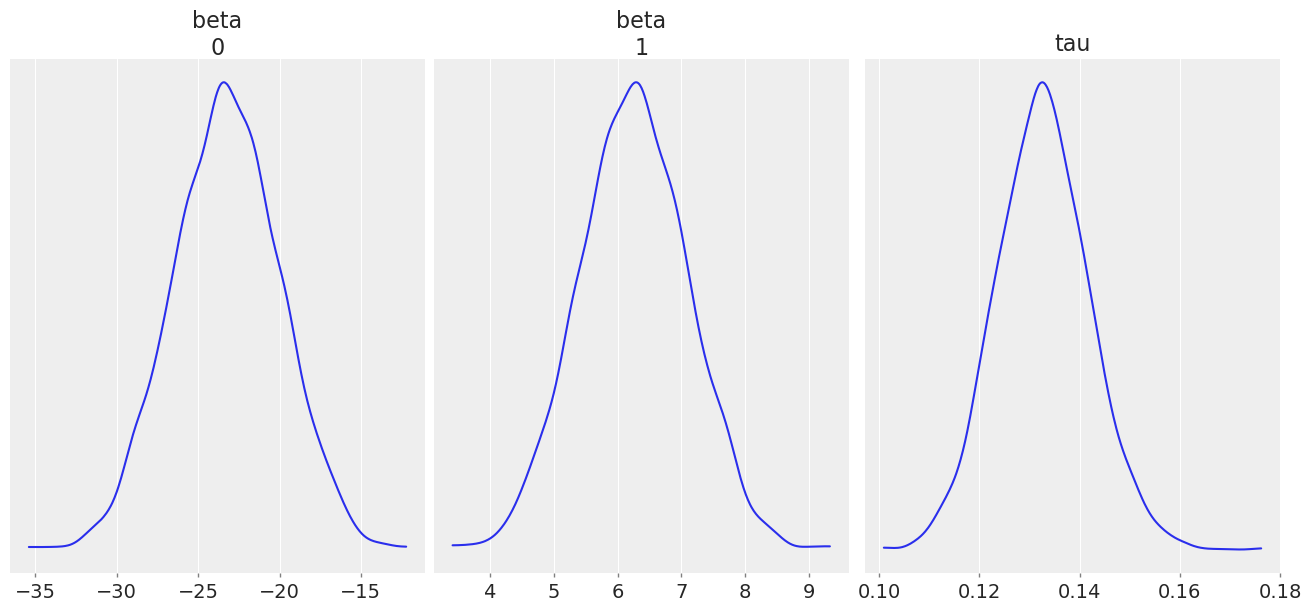

In [450]:
a = logL1_err ** (-2)
b = logT1_err ** (-2)
y_obs = y
x_obs = x1
c = d = 1e-3
e = f = 2

basic_model_set1 = Model()

with basic_model_set1:
    # Priors for unknown model parameters
    tau = Gamma('tau', alpha=e, beta=f)
    X1 = Normal("X1", mu=0, tau=tau, shape=212)
    beta = Normal('beta', mu=0, tau=d, shape=2)
    Y = Normal("Y", mu=beta[0] + beta[1]*X1, tau=tau)
    # Likelihood (sampling distribution) of observations
    Y_star = Normal('Y_star', mu=Y, tau=a, observed=y_obs)
    X1_star = Normal('X_star', mu=X1, tau=b, observed=x_obs)

map_estimate_set1 = find_MAP(model = basic_model) #*********

with basic_model_set1: #*********
    start_set1 = find_MAP()  #**********
    #step = pm.Metropolis()
    # draw 1000 posterior samples
    trace_set1 = pm.sample(cores=4, chains=4, start=start_set1, return_inferencedata=True, draws=1000) # step=step

posterior_set1 = trace_set1.posterior

with basic_model_set1:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

az.plot_posterior(trace_set1.posterior[["beta","tau"]],figsize=(13, 6), hdi_prob='hide', point_estimate=None)

/var/folders/36/5ssmgg1n0kgbmjfhm188d5br0000gn/T/ipykernel_71634/2292522887.py:28: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace_set2 = pm.sample(cores=4, chains=4, start=start_set2, return_inferencedata=True, draws=1000) # step=step
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, X1, beta, Y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
Sampling: [X_star, Y_star]


array([<AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>,
       <AxesSubplot: title={'center': 'tau'}>], dtype=object)

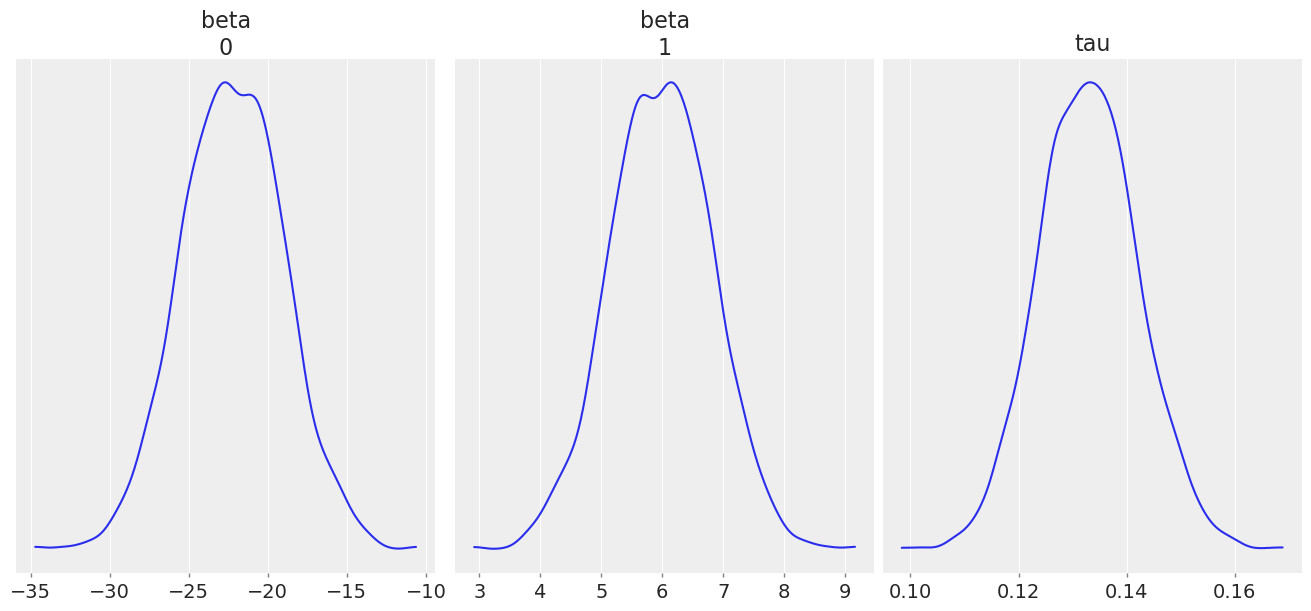

In [463]:
a = logL1_err ** (-2)
b = logT1_err ** (-2)
y_obs = y
x_obs = x1
c = 5e-3
d = 5e-3
e = 3
f = 5

basic_model_set2 = Model()

with basic_model_set2:
    # Priors for unknown model parameters
    tau = Gamma('tau', alpha=e, beta=f)
    X1 = Normal("X1", mu=0, tau=tau, shape=212)
    beta = Normal('beta', mu=0, tau=d, shape=2)
    Y = Normal("Y", mu=beta[0] + beta[1]*X1, tau=tau)
    # Likelihood (sampling distribution) of observations
    Y_star = Normal('Y_star', mu=Y, tau=a, observed=y_obs)
    X1_star = Normal('X_star', mu=X1, tau=b, observed=x_obs)

map_estimate_set2 = find_MAP(model = basic_model) #*********

with basic_model_set2: #*********
    start_set2 = find_MAP()  #**********
    #step = pm.Metropolis()
    # draw 1000 posterior samples
    trace_set2 = pm.sample(cores=4, chains=4, start=start_set2, return_inferencedata=True, draws=1000) # step=step

posterior_set2 = trace_set2.posterior

with basic_model_set2:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

az.plot_posterior(trace_set2.posterior[["beta","tau"]],figsize=(13, 6), hdi_prob='hide', point_estimate=None)

/var/folders/36/5ssmgg1n0kgbmjfhm188d5br0000gn/T/ipykernel_71634/2022302511.py:27: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace_set3 = pm.sample(cores=4, chains=4, start=start_set3, return_inferencedata=True, draws=1000) # step=step
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, X1, beta, Y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
Sampling: [X_star, Y_star]


array([<AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>,
       <AxesSubplot: title={'center': 'tau'}>], dtype=object)

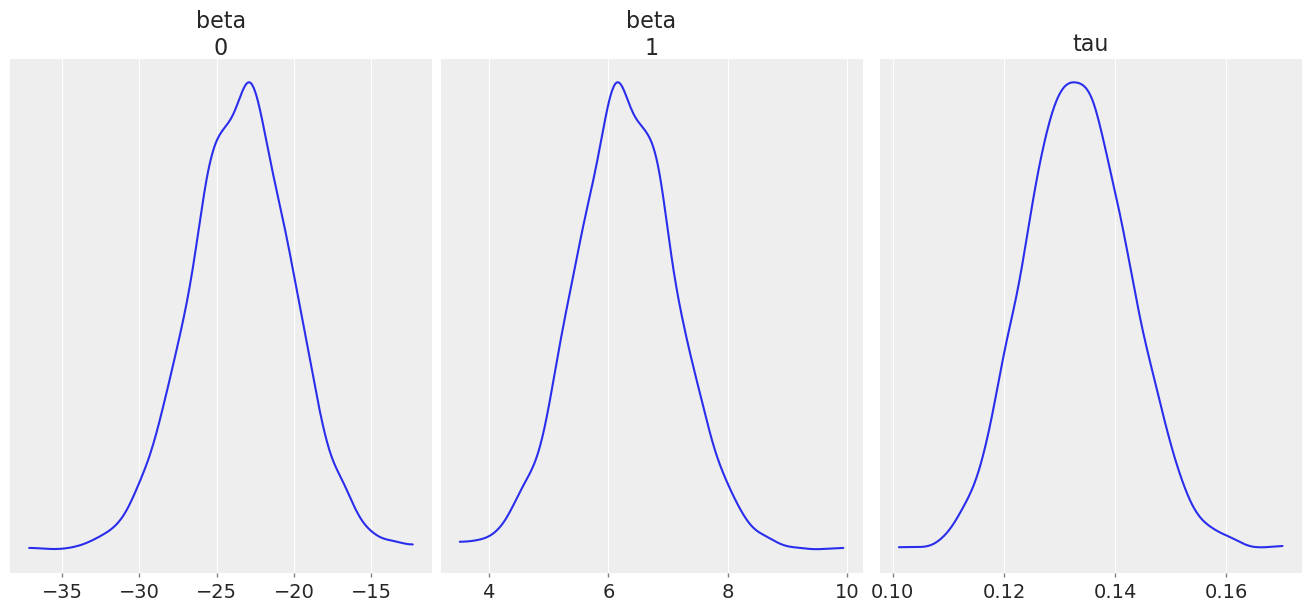

In [464]:
a = logL1_err ** (-2)
b = logT1_err ** (-2)
y_obs = y
x_obs = x1
c = d = 1e-4
e = 4
f = 9

basic_model_set3 = Model()

with basic_model_set3:
    # Priors for unknown model parameters
    tau = Gamma('tau', alpha=e, beta=f)
    X1 = Normal("X1", mu=0, tau=tau, shape=212)
    beta = Normal('beta', mu=0, tau=d, shape=2)
    Y = Normal("Y", mu=beta[0] + beta[1]*X1, tau=tau)
    # Likelihood (sampling distribution) of observations
    Y_star = Normal('Y_star', mu=Y, tau=a, observed=y_obs)
    X1_star = Normal('X_star', mu=X1, tau=b, observed=x_obs)

map_estimate_set3 = find_MAP(model = basic_model) #*********

with basic_model_set3: #*********
    start_set3 = find_MAP()  #**********
    #step = pm.Metropolis()
    # draw 1000 posterior samples
    trace_set3 = pm.sample(cores=4, chains=4, start=start_set3, return_inferencedata=True, draws=1000) # step=step

posterior_set3 = trace_set3.posterior

with basic_model_set3:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

az.plot_posterior(trace_set3.posterior[["beta","tau"]],figsize=(13, 6), hdi_prob='hide', point_estimate=None)

/var/folders/36/5ssmgg1n0kgbmjfhm188d5br0000gn/T/ipykernel_71634/3499859003.py:28: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace_set4 = pm.sample(cores=4, chains=4, start=start_set4, return_inferencedata=True, draws=1000) # step=step
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, X1, beta, Y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
Sampling: [X_star, Y_star]


array([<AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>,
       <AxesSubplot: title={'center': 'tau'}>], dtype=object)

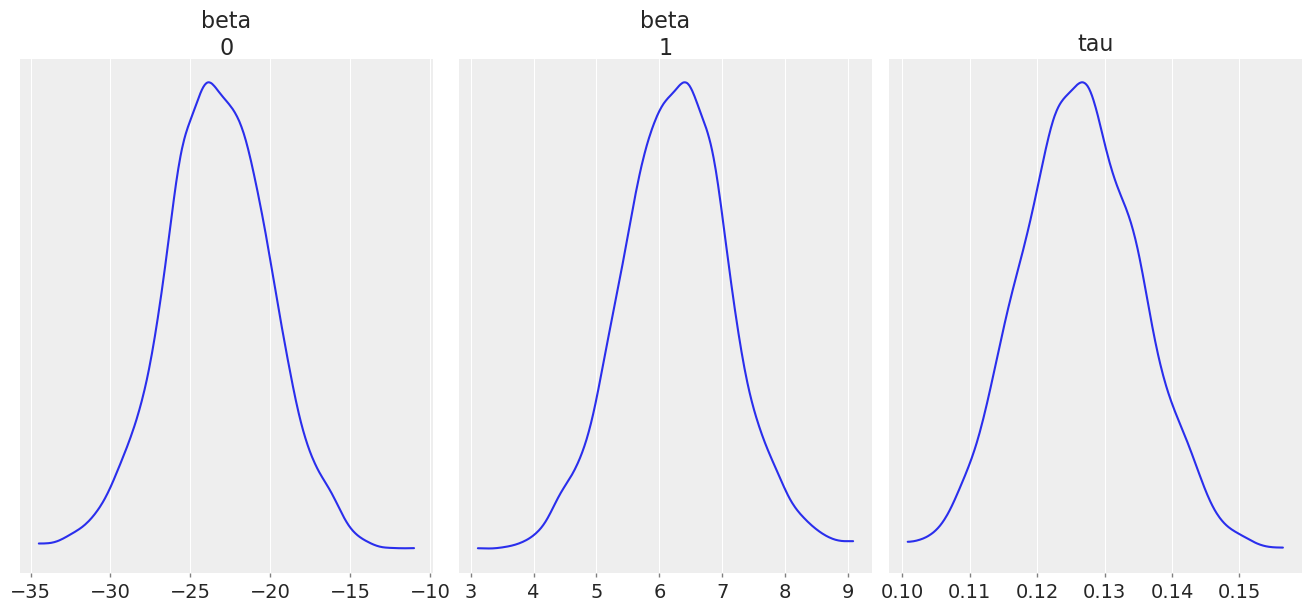

In [487]:
a = logL1_err ** (-2)
b = logT1_err ** (-2)
y_obs = y
x_obs = x1
c = 1e-5
d = 1e-5
e = 5
f = 10

basic_model_set4 = Model()

with basic_model_set4:
    # Priors for unknown model parameters
    tau = Gamma('tau', alpha=e, beta=f)
    X1 = Normal("X1", mu=0, tau=tau, shape=212)
    beta = Normal('beta', mu=0, tau=d, shape=2)
    Y = Normal("Y", mu=beta[0] + beta[1]*X1, tau=tau)
    # Likelihood (sampling distribution) of observations
    Y_star = Normal('Y_star', mu=Y, tau=a, observed=y_obs)
    X1_star = Normal('X_star', mu=X1, tau=b, observed=x_obs)

map_estimate_set4 = find_MAP(model = basic_model) #*********

with basic_model_set4: #*********
    start_set4 = find_MAP()  #**********
    #step = pm.Metropolis()
    # draw 1000 posterior samples
    trace_set4 = pm.sample(cores=4, chains=4, start=start_set4, return_inferencedata=True, draws=1000) # step=step

posterior_set4 = trace_set4.posterior

with basic_model_set4:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

az.plot_posterior(trace_set4.posterior[["beta","tau"]],figsize=(13, 6), hdi_prob='hide', point_estimate=None)

array([<AxesSubplot: title={'center': 'beta\n0'}>,
       <AxesSubplot: title={'center': 'beta\n1'}>,
       <AxesSubplot: title={'center': 'tau'}>], dtype=object)

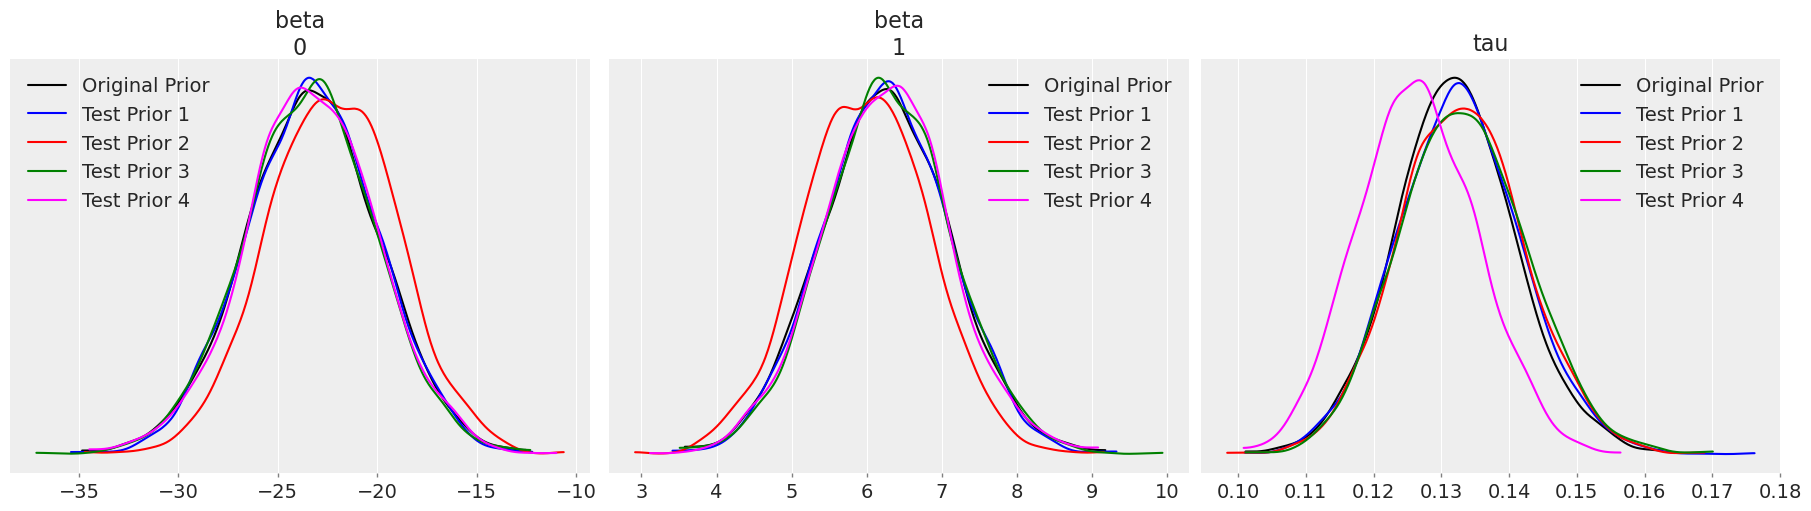

In [488]:
ax1 = az.plot_posterior(trace.posterior[["beta","tau"]],figsize=(18, 5), hdi_prob='hide', point_estimate=None, color='black', label='Original Prior')
az.plot_posterior(trace_set1.posterior[["beta","tau"]],figsize=(18, 5),ax=ax1, hdi_prob='hide', point_estimate=None, color='blue', label='Test Prior 1')
az.plot_posterior(trace_set2.posterior[["beta","tau"]],figsize=(18, 5),ax=ax1, hdi_prob='hide', point_estimate=None, color='red', label='Test Prior 2')
az.plot_posterior(trace_set3.posterior[["beta","tau"]],figsize=(18, 5),ax=ax1, hdi_prob='hide', point_estimate=None, color='green', label='Test Prior 3')
az.plot_posterior(trace_set4.posterior[["beta","tau"]],figsize=(18, 5),ax=ax1, hdi_prob='hide', point_estimate=None, color='magenta', label='Test Prior 4')
